# Intro

The following code provides you with surprisal values for the same data you used in Homework 2.  The surprisal values are based on the output of an RNN model.

We leave it up to you to perform the alignment between the model output and the reading times!

Feel free to skim through the code, it might be helpful for the semi-structured and open-ended tasks!
This includes the package used to train the RNN model, and compute the surprisals - [https://github.com/omershubi/neural-complexity.git](https://github.com/omershubi/neural-complexity.git).

## Set up dependencies and data

Run the cell below to fetch the recurrent neural network codebase we've designed for this assignment.

It will leave the files in a directory called `rnn` (check in the sidebar after you've run the command).

In [ ]:
%%bash
git clone https://github.com/omershubi/neural-complexity.git rnn
mkdir -p rnn/data/ptb

Cloning into 'rnn'...


## Mount Google Drive

We'll save your corpus data, model checkpoints, and output to your Google Drive for safekeeping.

Follow the instructions in the output of this command to link your Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

ValueError: mount failed

In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"

In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

## Upload corpus files for LM training

Here we upload the Penn Treebank corpus files  to the `rnn/data/ptb` folder.
Your files should be named:

- `ptb_tok_train.txt`
- `ptb_tok_dev.txt`

In [ ]:
!wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/omershubi/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/omershubi/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
!cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"

# Recurrent neural network modeling

## Train model

Now we're ready to begin training the model. The below command will launch the neural network optimization procedure, and progressively save checkpoints to the Google Drive you've just mounted. The neural network train for 40 epochs (1 epoch = 1 loop through the training dataset), which should take approximately **2 hours**.

Checkpoints will be saved each time the validation loss improves, and named `ptb_model.pt`. Watch the output of the command below to see how the model's train and validation perplexity improve over time.

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

Libraries loaded
| epoch   1 |   200/ 1422 batches | lr 20.00 | ms/batch 19.17 | loss  6.73 | ppl   837.07
| epoch   1 |   400/ 1422 batches | lr 20.00 | ms/batch 11.80 | loss  6.04 | ppl   421.34
| epoch   1 |   600/ 1422 batches | lr 20.00 | ms/batch 11.79 | loss  5.90 | ppl   365.32
| epoch   1 |   800/ 1422 batches | lr 20.00 | ms/batch 11.83 | loss  5.83 | ppl   341.77
| epoch   1 |  1000/ 1422 batches | lr 20.00 | ms/batch 11.84 | loss  5.84 | ppl   342.74
| epoch   1 |  1200/ 1422 batches | lr 20.00 | ms/batch 11.86 | loss  5.78 | ppl   324.46
| epoch   1 |  1400/ 1422 batches | lr 20.00 | ms/batch 11.92 | loss  5.82 | ppl   336.83
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 18.50s | lr: 20.00000000 | valid ppl   270.29
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1422 batches | lr 20.00 | ms/batch 12.23 | loss  5.83 | ppl   339.01
| epoch   

## Compute surprisals

Now we'll compute model surprisals for the text data in `brown.txt` (already downloaded for you). This will output a file called `rnn_surprisals.tsv` to your Google Drive, which you'll use in the next steps of the analysis.

We'll load the checkpoint and use it to extract per-token surprisal estimates.

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


Cool, let's check that the surprisal output looks right. (Compare with the ngram model surprisals from before.)

In [ ]:
import pandas as pd
# rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals = pd.read_csv(f'rnn_surprisals.tsv',sep=' ')
rnn_surprisals.head(10)

word  sentid  sentpos  wlen       surp    entropy    entred
0      In       0        0     2   5.506053   9.515585  0.000000
1   <unk>       0        1     5   6.578504   7.866125  1.649460
2  County       0        2     6  12.514248   6.056062  1.810063
3   <unk>       0        3     5   7.031470   8.524199  0.000000
4    near       0        4     4  13.308077   8.640187  0.000000
5     the       0        5     3   1.662673   7.870934  0.769253
6   River       0        6     5  17.830992  11.037002  0.000000
7   <unk>       0        7     5   5.396320   9.381214  1.655787
8   there       0        8     5  13.024343   8.804840  0.576374
9      is       0        9     2   2.341246   4.669997  4.134843

## Harmonize RNN surprisal and RT data

Load and align the reading times with the n-gram model surprisals.
You may load the harmonized csv from Homework 2, or align it again.

Finallyy, align the RNN model-derived surprisal values with human reading times. The harmonize function you wrote in Homework 2 may be helpful here too.

Note, modifications may be required as the tokenization is not necessarily the same as the n-gram model.

In [ ]:
import re
import pandas as pd

# rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals = pd.read_csv(f'rnn_surprisals.tsv',sep=' ')
sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')

def harmonize(rt_data: pd.DataFrame, surprs_data: pd.DataFrame) -> pd.DataFrame:

    def reset(RNN_df, RT_df):
      RT_df.reset_index(drop=True, inplace=True)
      RNN_df.reset_index(drop=True, inplace=True)

    def extract_word(word):
      return "".join(re.findall(r"[A-Za-z]+", word))

    def average(rt_df):
      return rt_df.groupby("code", as_index=False).mean('time')

    def remove_start_end_tokens(RNN_df):
      return RNN_df[RNN_df['word'] != "<unk>"]

    def exclude_outliers(rt_df):
      return rt_df[(rt_df['time'] > 80) & (rt_df['time'] < 1500)]

    # Function to get the surrounding rows
    def get_surrounding_rows(df, index, n=2):
      start = max(index - n, 0)
      end = min(index + n + 1, len(df))
      return df.iloc[start:end]

    # Excluding the outliers from the RT dataframe
    rt = exclude_outliers(sprt)

    # Averaging the reading time across participants
    avg_time = average(rt)[['code', 'time']]

    # Merging the RT dataframe, obtaining average reading time per word in context
    word_context_pairs = rt[['code', 'word']].drop_duplicates()
    RT_df = pd.merge(avg_time, word_context_pairs, on='code')

    # Removing the rows containing "--"
    RNN_df = rnn_surprisals
    RNN_df = RNN_df[RNN_df['word'] != "--"][['word', 'surp']]
    # Changing the name of the column from 'token' to 'word'
    RT_df.rename(columns={'time': 'mean_rt'}, inplace=True)

    RT_df['word'] = RT_df['word'].str.replace(' --', '', regex=True)

    # Reset index in both dataframes
    RT_df.reset_index(drop=True, inplace=True)
    RNN_df.reset_index(drop=True, inplace=True)

    RNN_df = RNN_df.drop(3460)
    reset(RNN_df, RT_df)
    RNN_df = RNN_df.drop(4453)
    reset(RNN_df, RT_df)
    RNN_df = RNN_df.drop(4472)
    reset(RNN_df, RT_df)

    # Iterate through the DataFrames to align and mark indices to drop
    rt_drop = []
    rnn_drop = []
    i, j = 0, 0
    while i < len(RT_df) and j < len(RNN_df):

        if RNN_df.iloc[i]['word'] == "<unk>" or re.search(r'[.,;]', RT_df.iloc[i]['word']):
            rt_drop.append(i)
            rnn_drop.append(j)
        i += 1
        j += 1

    RT_df.drop(rt_drop, inplace=True)
    RNN_df.drop(rnn_drop, inplace=True)

    # Reset index in both dataframes
    RT_df.reset_index(drop=True, inplace=True)
    RNN_df.reset_index(drop=True, inplace=True)

    RNN_df = RNN_df.drop(2628)
    RT_df = RT_df.drop(2629)
    reset(RNN_df, RT_df)

    print(f"After cleaning, RNN length: {len(RNN_df)}")
    print(f"After cleaning, RT length: {len(RT_df)}")


    RT_df['surprisal'] = RNN_df['surp']
    RT_df['wlen'] = RT_df['word'].apply(lambda x: len(x))
    return RT_df


harmonized_df = harmonize(sprt, rnn_surprisals)
harmonized_df

After cleaning, RNN length: 5469
After cleaning, RT length: 5469


code     mean_rt    word  surprisal  wlen
0     17000  380.275294      In   5.506053     2
1     17002  296.042941  County  12.514248     6
2     17004  403.553529    near  13.308077     4
3     17005  306.075882     the   1.662673     3
4     17006  289.048235   River  17.830992     5
...     ...         ...     ...        ...   ...
5464  35758  292.772500  failed   9.048445     6
5465  35759  284.470833      as   6.248776     2
5466  35760  282.622083       a   2.861911     1
5467  35761  279.445417  leader  11.365563     6
5468  35762  299.705000     and   6.632089     3

[5469 rows x 5 columns]

In [ ]:
harmonized_df.to_csv(f'rnn_surprisals.csv')

# Structured task

## Part 1

Fitting the linear regression model

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

data_rnn = pd.read_csv("/content/gdrive/MyDrive/096222_project_surprisals_and_rts/surprisals/rnn_surprisals.csv")
data_n_gram = pd.read_csv("/content/gdrive/MyDrive/096222_project_surprisals_and_rts/surprisals/n_gram_surprisals.csv")

# Fit and summarize OLS model for RNN surprisal data
Y_rnn = data_rnn['mean_rt']
X_rnn = data_rnn['surprisal']
X_rnn = sm.add_constant(X_rnn)

lin_model = sm.OLS(Y_rnn, X_rnn).fit()

print(f"--------------------------RNN Surprisal Data Fit-----------------------")
print(lin_model.summary())
print('\n\n\n\n\n')

# Fit and summarize OLS model for N-Gram surprisal data
Y_ngram = data_n_gram['mean_rt']
X_ngram = data_n_gram['surprisal']
X_ngram = sm.add_constant(X_ngram)

lin_model = sm.OLS(Y_ngram, X_ngram).fit()

print(f"--------------------------N-Gram Surprisal Data Fit-----------------------")
print(lin_model.summary())
print()

--------------------------RNN Surprisal Data Fit-----------------------
                            OLS Regression Results                            
Dep. Variable:                mean_rt   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     232.6
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           1.84e-51
Time:                        09:41:15   Log-Likelihood:                -28458.
No. Observations:                5469   AIC:                         5.692e+04
Df Residuals:                    5467   BIC:                         5.693e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

The first model is marginally better than the second model based on the metrics discussed. It has higher R-squared and Adjusted R-squared values, a higher F-statistic, stronger coefficients, and lower AIC and BIC values, indicating it better explains the variance in the dependent variable (mean_rt). However, the differences between the two models are not substantial, suggesting both models perform similarly.

Without binning

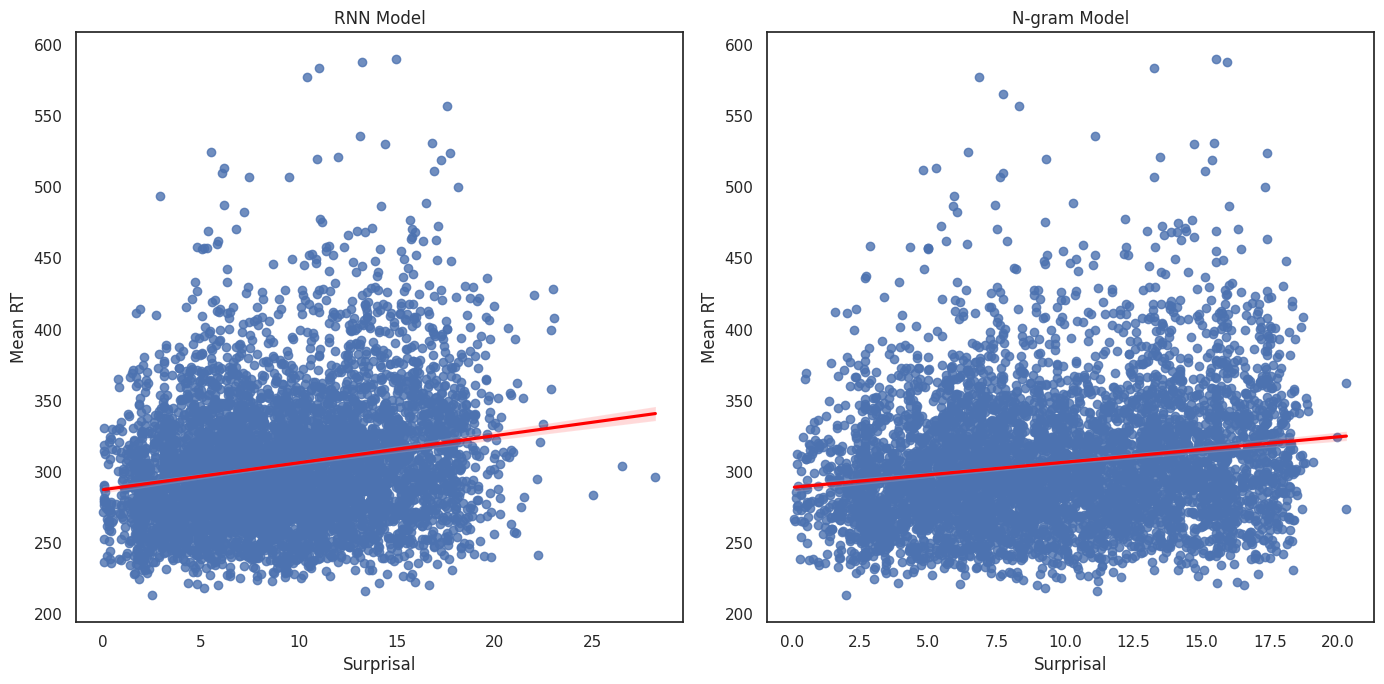

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

sns.set(style="white", color_codes=True)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

# First plot for the RNN data
sns.regplot(x="surprisal", y="mean_rt", data=data_rnn, ax=ax1, line_kws={"color": "red"})
ax1.set_title("RNN Model")
ax1.set_xlabel("Surprisal")
ax1.set_ylabel("Mean RT")

# Second plot for the N-gram data
sns.regplot(x="surprisal", y="mean_rt", data=data_n_gram, ax=ax2, line_kws={"color": "red"})
ax2.set_title("N-gram Model")
ax2.set_xlabel("Surprisal")
ax2.set_ylabel("Mean RT")

# Tight layout to avoid overlap
plt.tight_layout()
plt.show()



With binning

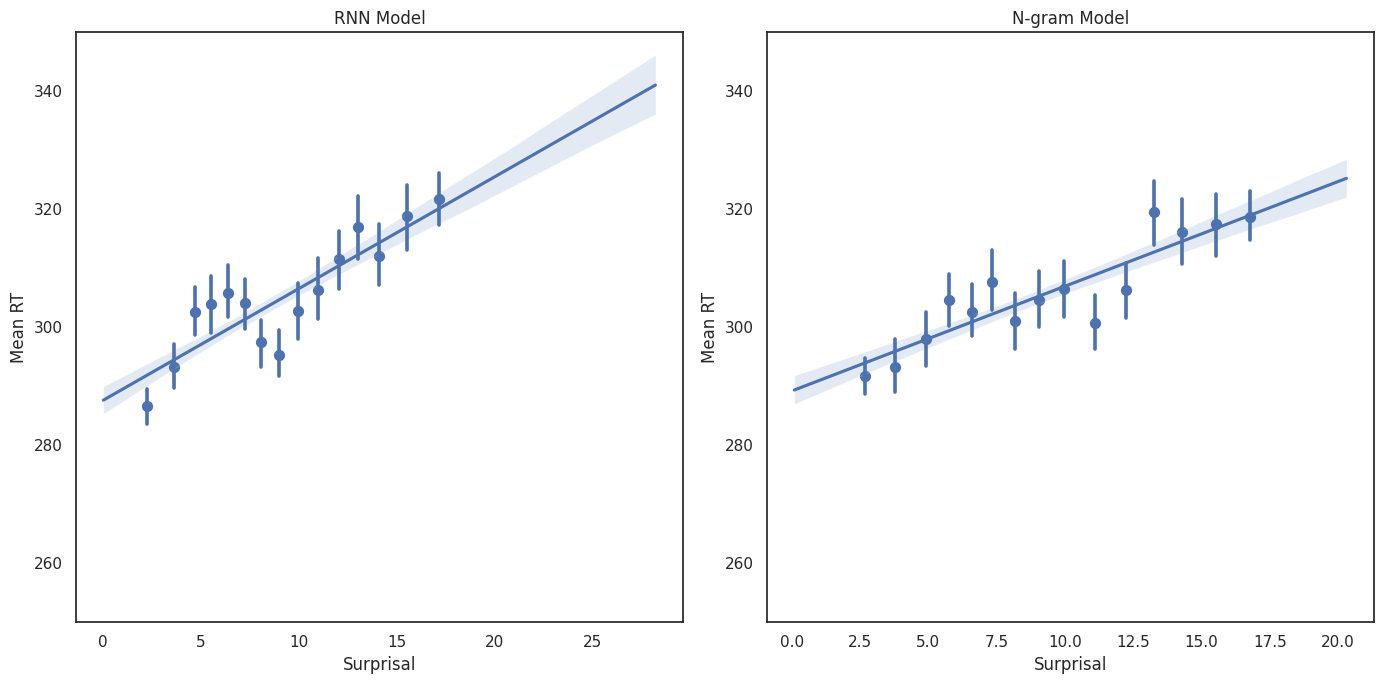

In [ ]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

# First plot for the RNN data with x_bins=15 and y-axis limit [250, 350]
sns.regplot(x="surprisal", y="mean_rt", data=data_rnn, x_bins=15, ax=ax1)
ax1.set_ylim([250, 350])
ax1.set_title("RNN Model")
ax1.set_xlabel("Surprisal")
ax1.set_ylabel("Mean RT")

# Second plot for the N-gram data with x_bins=15 and y-axis limit [250, 350]
sns.regplot(x="surprisal", y="mean_rt", data=data_n_gram, x_bins=15, ax=ax2)
ax2.set_ylim([250, 350])
ax2.set_title("N-gram Model")
ax2.set_xlabel("Surprisal")
ax2.set_ylabel("Mean RT")

# Tight layout to avoid overlap
plt.tight_layout()

## Part 2

In [ ]:
# Merge the two dataframes on the 'word' column
merged_df = pd.merge(data_rnn, data_n_gram, on='code', suffixes=('_rnn', '_ngram'))
print(merged_df)

# Prepare the data for the linear regression model
X = merged_df['surprisal_rnn']  # Independent variables
y = merged_df['surprisal_ngram']  # Dependent variable (using mean_rt from RNN data)
X = sm.add_constant(X)  # Add a constant to the model

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())


      Unnamed: 0_rnn   code  mean_rt_rnn word_rnn  surprisal_rnn  wlen  \
0                  0  17000   380.275294       In       5.506053     2   
1                  1  17002   296.042941   County      12.514248     6   
2                  2  17004   403.553529     near      13.308077     4   
3                  3  17005   306.075882      the       1.662673     3   
4                  4  17006   289.048235    River      17.830992     5   
...              ...    ...          ...      ...            ...   ...   
5359            5464  35758   292.772500   failed       9.048445     6   
5360            5465  35759   284.470833       as       6.248776     2   
5361            5466  35760   282.622083        a       2.861911     1   
5362            5467  35761   279.445417   leader      11.365563     6   
5363            5468  35762   299.705000      and       6.632089     3   

      Unnamed: 0_ngram  mean_rt_ngram word_ngram  surprisal_ngram  
0                    0     380.275294      

<ipython-input-9-ab3710128a36>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]
<ipython-input-9-ab3710128a36>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]


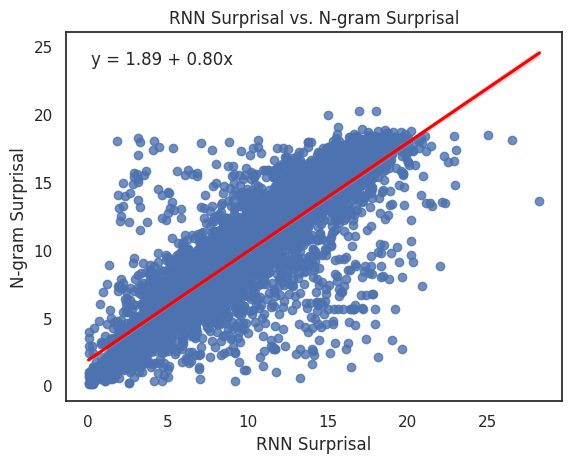

In [ ]:
# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Extract the coefficients
intercept = model.params[0]
slope = model.params[1]

# Plot the linear regression line
sns.regplot(x='surprisal_rnn', y='surprisal_ngram', data=merged_df, line_kws={"color": "red"})
plt.xlabel('RNN Surprisal')
plt.ylabel('N-gram Surprisal')
# Add the regression equation to the plot
equation = f'y = {intercept:.2f} + {slope:.2f}x'
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title('RNN Surprisal vs. N-gram Surprisal')
plt.show()


## Part 3

In [ ]:
# Filter the DataFrame for points within the specified ranges
filtered_df = merged_df[(merged_df['surprisal_rnn'] >= 0) & (merged_df['surprisal_rnn'] <= 5) &
                        (merged_df['surprisal_ngram'] >= 10) & (merged_df['surprisal_ngram'] <= 17)]

# Print the filtered DataFrame
print(filtered_df)

       code  mean_rt_rnn word_rnn  surprisal_rnn  Unnamed: 0  mean_rt_ngram  \
2493  26353   324.235238       no       2.865324        3274     324.235238   
2527  26430   254.863333        a       3.607280        3351     254.863333   
2556  26498   354.016190      the       3.264447        3419     354.016190   
2557  26501   274.077143      and       4.885086        3422     274.077143   
2559  26503   261.124286      the       2.168802        3424     261.124286   
2566  26518   270.740476      the       2.051040        3439     270.740476   
3091  28115   292.433333      the       1.904777        4163     292.433333   
3105  29011   360.515000      the       2.207029        4189     360.515000   
3107  29019   291.516250        a       3.137901        4197     291.516250   
3140  29067   315.843750        a       3.060724        4245     315.843750   
3146  29079   346.708125      and       4.613364        4257     346.708125   
3151  29088   306.070000      the       3.118093    

In [ ]:
reading_dataset = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')


1.   The RNN and N-gram models are generally well matched, showing a significant correlation in their surprisal predictions. The slope of the regression line (0.80) indicates that while both models agree on the general trend. \
At lower surprisal values, the models are closely aligned, but the N-gram model tends to predict slightly higher baseline surprisal values, even when the RNN surprisal is near zero. \
As surprisal increases, the models begin to diverge. The N-gram model’s predictions increase less steeply compared to the RNN.\
At the highest surprisal levels, the divergence is more pronounced. The RNN model predicts much higher surprisal.At lower surprisal values, the models are closely aligned, but the N-gram model tends to predict slightly higher baseline surprisal values, even when the RNN surprisal is near zero.

2.  The RNN assigns low surprisal to these words because it effectively utilizes the full context of the sentence, recognizing them as predictable. The n-gram model assigns higher surprisal because it is more rigid, relying on the exactness of shorter word sequences, and may not predict these common words well if their immediate preceding context is uncommon in its training data.





## Part 4

In [ ]:
print("-------RNN Surprisal Data------------")
print(data_rnn.head())

print("\n\n-------N-Gram Surprisal Data------------")
print(data_n_gram.head())

print("\n\n-------Merged Data------------")
print(merged_df.head())

# save merged df to csv
merged_df.to_csv('merged_data.csv', index=False)

-------RNN Surprisal Data------------
   Unnamed: 0   code     mean_rt    word  surprisal
0           0  17000  380.275294      In   5.506053
1           1  17002  296.042941  County  12.514248
2           2  17004  403.553529    near  13.308077
3           3  17005  306.075882     the   1.662673
4           4  17006  289.048235   River  17.830992


-------N-Gram Surprisal Data------------
   Unnamed: 0   code     mean_rt    word  surprisal
0           0  17000  380.275294      In    4.57937
1           2  17002  296.042941  County   12.65410
2           4  17004  403.553529    near   12.22380
3           5  17005  306.075882     the    1.98095
4           6  17006  289.048235   River   15.70900


-------Merged Data------------
    code  mean_rt_rnn word_rnn  surprisal_rnn  Unnamed: 0  mean_rt_ngram  \
0  17000   380.275294       In       5.506053           0     380.275294   
1  17002   296.042941   County      12.514248           2     296.042941   
2  17004   403.553529     near    

In [ ]:
import numpy as np
import pandas as pd

# Calculate probability from surprisal for both RNN and N-Gram models
merged_df['rnn_probability'] = 2 ** (-merged_df['surprisal_rnn'])
merged_df['ngram_probability'] = 2 ** (-merged_df['surprisal_ngram'])

# Calculate the next word's reading time by shifting the mean RT column
merged_df['rnn_next_mean_rt'] = merged_df['mean_rt_rnn'].shift(-1)
merged_df['ngram_next_mean_rt'] = merged_df['mean_rt_ngram'].shift(-1)

# Drop rows where the next_mean_rt would be NaN (typically the last row after shifting)
merged_df.dropna(subset=['rnn_next_mean_rt', 'ngram_next_mean_rt'], inplace=True)

# Create the df_combined DataFrame
df_combined = pd.DataFrame({
    'rnn_probability': merged_df['rnn_probability'],
    'rnn_mean_rt': merged_df['mean_rt_rnn'],
    'rnn_next_mean_rt': merged_df['rnn_next_mean_rt'],
    'ngram_probability': merged_df['ngram_probability'],
    'ngram_mean_rt': merged_df['mean_rt_ngram'],
    'ngram_next_mean_rt': merged_df['ngram_next_mean_rt']
})

# Log-transform the probability for both models
df_combined['rnn_log_probability'] = np.log2(df_combined['rnn_probability'])
df_combined['ngram_log_probability'] = np.log2(df_combined['ngram_probability'])

# Replace any infinity values resulting from log(0) with NaN, then drop NaN values
df_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
df_combined.dropna(inplace=True)

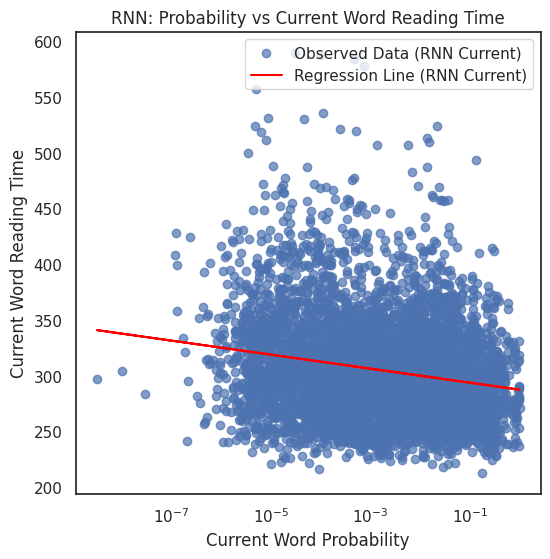

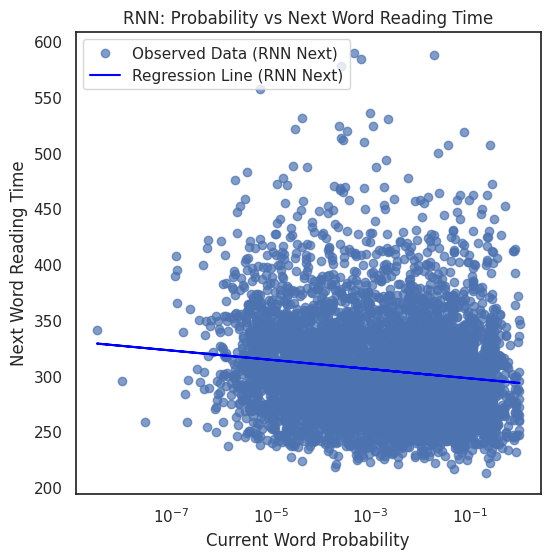

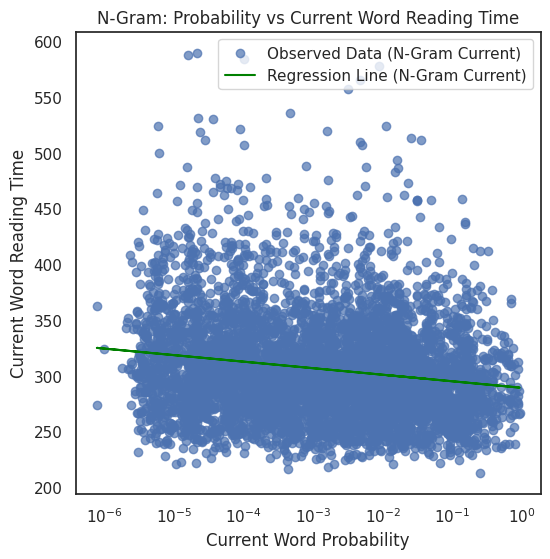

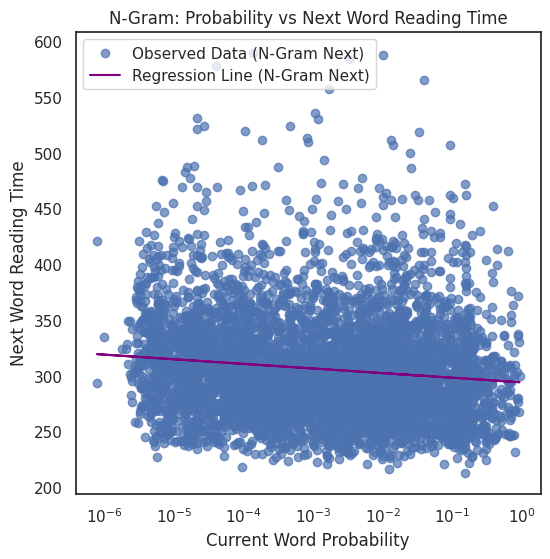

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

data_rnn['probability'] = 2 ** (-data_rnn['surprisal'])
data_rnn['next_mean_rt'] = data_rnn['mean_rt'].shift(-1)
data_rnn.dropna(inplace=True)

data_n_gram['probability'] = 2 ** (-data_n_gram['surprisal'])
data_n_gram['next_mean_rt'] = data_n_gram['mean_rt'].shift(-1)
data_n_gram.dropna(inplace=True)

# Drop the last row since it will have NaN in `next_mean_rt`
data_n_gram.dropna(inplace=True)

# Step 1: Prepare the new DataFrame
df_combined = pd.DataFrame({
    'rnn_probability': data_rnn['probability'],
    'rnn_mean_rt': data_rnn['mean_rt'],
    'rnn_next_mean_rt': data_rnn['next_mean_rt'],
    'ngram_probability': data_n_gram['probability'],
    'ngram_mean_rt': data_n_gram['mean_rt'],
    'ngram_next_mean_rt': data_n_gram['next_mean_rt']
})

# Log-transform the probability for both models
df_combined['rnn_log_probability'] = np.log2(df_combined['rnn_probability'])
df_combined['ngram_log_probability'] = np.log2(df_combined['ngram_probability'])

# convert infinity to Nan and drop NaNs
df_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
df_combined.dropna(inplace=True)

# Step 2: Fit a linear regression model for RNN
X_rnn_current = df_combined['rnn_log_probability']
y_rnn_current = df_combined['rnn_mean_rt']
X_rnn_current = sm.add_constant(X_rnn_current)
model_rnn_current = sm.OLS(y_rnn_current, X_rnn_current).fit()

y_rnn_next = df_combined['rnn_next_mean_rt']
X_rnn_next = sm.add_constant(df_combined['rnn_log_probability'])
model_rnn_next = sm.OLS(y_rnn_next, X_rnn_next).fit()

# Predict the reading times based on the fitted models
df_combined['rnn_predicted_rt_current'] = model_rnn_current.predict(X_rnn_current)
df_combined['rnn_predicted_rt_next'] = model_rnn_next.predict(X_rnn_next)

# Step 3: Fit a linear regression model for N-Gram
X_ngram_current = df_combined['ngram_log_probability']
y_ngram_current = df_combined['ngram_mean_rt']
X_ngram_current = sm.add_constant(X_ngram_current)
model_ngram_current = sm.OLS(y_ngram_current, X_ngram_current).fit()

y_ngram_next = df_combined['ngram_next_mean_rt']
X_ngram_next = sm.add_constant(df_combined['ngram_log_probability'])
model_ngram_next = sm.OLS(y_ngram_next, X_ngram_next).fit()

# Predict the reading times based on the fitted models
df_combined['ngram_predicted_rt_current'] = model_ngram_current.predict(X_ngram_current)
df_combined['ngram_predicted_rt_next'] = model_ngram_next.predict(X_ngram_next)

# Step 4: Plot the original data and the regression lines for both RNN and N-Gram
plt.figure(figsize=(6,6))
plt.scatter(df_combined['rnn_probability'], df_combined['rnn_mean_rt'], alpha=0.7, label='Observed Data (RNN Current)')
plt.plot(df_combined['rnn_probability'], df_combined['rnn_predicted_rt_current'], color='red', label='Regression Line (RNN Current)')
plt.title('RNN: Probability vs Current Word Reading Time')
plt.xlabel('Current Word Probability')
plt.ylabel('Current Word Reading Time')
plt.xscale('log')  # Log scale for the x-axis
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df_combined['rnn_probability'], df_combined['rnn_next_mean_rt'], alpha=0.7, label='Observed Data (RNN Next)')
plt.plot(df_combined['rnn_probability'], df_combined['rnn_predicted_rt_next'], color='blue', label='Regression Line (RNN Next)')
plt.title('RNN: Probability vs Next Word Reading Time')
plt.xlabel('Current Word Probability')
plt.ylabel('Next Word Reading Time')
plt.xscale('log')  # Log scale for the x-axis
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df_combined['ngram_probability'], df_combined['ngram_mean_rt'], alpha=0.7, label='Observed Data (N-Gram Current)')
plt.plot(df_combined['ngram_probability'], df_combined['ngram_predicted_rt_current'], color='green', label='Regression Line (N-Gram Current)')
plt.title('N-Gram: Probability vs Current Word Reading Time')
plt.xlabel('Current Word Probability')
plt.ylabel('Current Word Reading Time')
plt.xscale('log')  # Log scale for the x-axis
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df_combined['ngram_probability'], df_combined['ngram_next_mean_rt'], alpha=0.7, label='Observed Data (N-Gram Next)')
plt.plot(df_combined['ngram_probability'], df_combined['ngram_predicted_rt_next'], color='purple', label='Regression Line (N-Gram Next)')
plt.title('N-Gram: Probability vs Next Word Reading Time')
plt.xlabel('Current Word Probability')
plt.ylabel('Next Word Reading Time')
plt.xscale('log')  # Log scale for the x-axis
plt.legend()
plt.show()

# Tight layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# print the summaries
print("Summary of RNN Current Reading Time Model:")
print(model_rnn_current.summary())

Summary of RNN Current Reading Time Model:
                            OLS Regression Results                            
Dep. Variable:            rnn_mean_rt   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     232.5
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           1.90e-51
Time:                        11:17:04   Log-Likelihood:                -28453.
No. Observations:                5468   AIC:                         5.691e+04
Df Residuals:                    5466   BIC:                         5.692e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [ ]:
print("\n\nSummary of RNN Next Reading Time Model:")
print(model_rnn_next.summary())



Summary of RNN Next Reading Time Model:
                            OLS Regression Results                            
Dep. Variable:       rnn_next_mean_rt   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     99.86
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           2.60e-23
Time:                        11:17:17   Log-Likelihood:                -28516.
No. Observations:                5468   AIC:                         5.704e+04
Df Residuals:                    5466   BIC:                         5.705e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [ ]:
print("\n\nSummary of N-Gram Current Reading Time Model:")
print(model_ngram_current.summary())



Summary of N-Gram Current Reading Time Model:
                            OLS Regression Results                            
Dep. Variable:          ngram_mean_rt   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     178.6
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           4.23e-40
Time:                        11:17:36   Log-Likelihood:                -28557.
No. Observations:                5468   AIC:                         5.712e+04
Df Residuals:                    5466   BIC:                         5.713e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [ ]:
print("\n\nSummary of N-Gram Next Reading Time Model:")
print(model_ngram_next.summary())



Summary of N-Gram Next Reading Time Model:
                            OLS Regression Results                            
Dep. Variable:     ngram_next_mean_rt   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     87.67
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           1.11e-20
Time:                        11:17:44   Log-Likelihood:                -28600.
No. Observations:                5468   AIC:                         5.720e+04
Df Residuals:                    5466   BIC:                         5.722e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [ ]:
sprt.head()

word   code subject  text_id  text_pos  word_in_exp    time
2286     In  17000    s001        0         0         2285  399.90
109460   In  17000    s028        0         0         2503  290.32
50709    In  17000    s014        0         0         1394  501.59
80486    In  17000    s021        0         0         2525  210.93
35626    In  17000    s010        0         0          579  862.35

# Semi-Structured Task

## Wiki - Task 3

### Training a RNN

In [ ]:
!wget -qO rnn/data/wikitext-2/train.txt https://github.com/OmerShubi/neural-complexity/blob/master/data/wikitext-2/train.txt
!wget -qO rnn/data/wikitext-2/test.txt https://github.com/OmerShubi/neural-complexity/blob/master/data/wikitext-2/test.txt
!cp rnn/data/wikitext-2/* "$GDRIVE_DIR/corpus_data/"

In [ ]:
# Training on wikitext-2 file, default file location is wikitext-2
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/wiki_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/wiki_vocab.txt" \
    --tied --trainfname "train.txt" --validfname "valid.txt"

Libraries loaded
| epoch   1 |   200/ 3052 batches | lr 20.00 | ms/batch 24.31 | loss  9.27 | ppl 10583.37
| epoch   1 |   400/ 3052 batches | lr 20.00 | ms/batch 15.18 | loss  9.18 | ppl  9689.00
| epoch   1 |   600/ 3052 batches | lr 20.00 | ms/batch 15.17 | loss  9.19 | ppl  9806.75
| epoch   1 |   800/ 3052 batches | lr 20.00 | ms/batch 15.21 | loss  9.36 | ppl 11566.94
| epoch   1 |  1000/ 3052 batches | lr 20.00 | ms/batch 15.23 | loss  9.20 | ppl  9854.12
| epoch   1 |  1200/ 3052 batches | lr 20.00 | ms/batch 15.23 | loss  9.23 | ppl 10150.42
| epoch   1 |  1400/ 3052 batches | lr 20.00 | ms/batch 15.27 | loss  9.15 | ppl  9404.96
| epoch   1 |  1600/ 3052 batches | lr 20.00 | ms/batch 15.39 | loss  9.18 | ppl  9726.17
| epoch   1 |  1800/ 3052 batches | lr 20.00 | ms/batch 15.41 | loss  9.18 | ppl  9666.52
| epoch   1 |  2000/ 3052 batches | lr 20.00 | ms/batch 15.41 | loss  8.92 | ppl  7479.77
| epoch   1 |  2200/ 3052 batches | lr 20.00 | ms/batch 15.47 | loss  9.32 | ppl 11

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/wiki_model.pt" \
    --vocab_file "$GDRIVE_DIR/wiki_vocab.txt" --data_dir '/content/rnn/data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_wiki_surprisals.tsv"

Libraries loaded
Using beamsize: 33278


### Traning an N-Gram model.

In [ ]:
import nltk
from nltk.util import ngrams
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from math import log

# Paths to the files
train = '/content/rnn/data/wikitext-2/train.txt'
test = '/content/rnn/data/wikitext-2/test.txt'
val = '/content/rnn/data/wikitext-2/valid.txt'
paths = [train, test, val]

combined_content = ""

# Iterate through each file
for file_path in paths:
    with open(file_path, 'r') as file:
        # Read the content of the file
        content = file.read().strip()  # .strip() to remove any leading/trailing spaces or newlines

        # Add the content to the combined content, separated by a space
        if combined_content:
            combined_content += "\n" + content
        else:
            combined_content = content

# Optionally, you can write the combined content to a new file
with open('train_file.txt', 'w') as output_file:
    output_file.write(combined_content)
test_file = '/content/rnn/data/brown.txt'
train_file = 'train_file.txt'

# Load training and test data
with open(train_file, 'r') as file:
    train_data = file.read()

with open(test_file, 'r') as file:
    test_data = file.read()

# Tokenize the text by splitting based on spaces and remove commas
def tokenize_and_add_bos(text):
    tokens = [token for token in text.split() if token != ',']
    sentences = nltk.sent_tokenize(text)
    tokenized_sentences = []
    for sentence in sentences:
        sentence_tokens = [token for token in sentence.split() if token != ',']
        tokenized_sentences.append(['BOS', 'BOS', 'BOS', 'BOS'] + sentence_tokens + ['EOS'])
    return [token for sentence in tokenized_sentences for token in sentence]

train_tokens = tokenize_and_add_bos(train_data)
test_tokens = tokenize_and_add_bos(test_data)

# Define n-gram order
n = 2
alpha = 0.01  # Smoothing parameter

# Count the n-grams and (n-1)-grams in the training data
n_grams_counts = defaultdict(int)
n_minus_1_grams_counts = defaultdict(int)
vocab = set(train_tokens)

for i in range(len(train_tokens) - n + 1):
    n_gram = tuple(train_tokens[i:i + n])
    n_grams_counts[n_gram] += 1
    n_minus_1_gram = n_gram[:-1]
    n_minus_1_grams_counts[n_minus_1_gram] += 1

V = len(vocab)

# Calculate the probability and surprisal for each word in the test data
surprisal_values = []

for i in range(n-1, len(test_tokens)):
    context = tuple(test_tokens[i - n + 1:i])
    word = test_tokens[i]

    # Skip the calculation if the word is 'BOS'
    if word == 'BOS':
        continue

    n_gram = context + (word,)
    n_gram_count = n_grams_counts[n_gram] + alpha
    n_minus_1_gram_count = n_minus_1_grams_counts[context] + alpha * V

    # Calculate the smoothed probability
    prob = n_gram_count / n_minus_1_gram_count

    # Compute the surprisal as the negative log probability
    surprisal = -log(prob)
    surprisal_values.append((word, surprisal))

# Create a DataFrame and save it as a CSV file
df = pd.DataFrame(surprisal_values, columns=['Word', 'Surprisal'])
csv_file = '/content/surprisal_values.csv'
df.to_csv(csv_file, index=False)

print(f"Surprisal values saved to {csv_file}")


Surprisal values saved to /content/surprisal_values.csv


In [ ]:
import string
n_gram_new = pd.read_csv('surprisals_brown.tsv', sep='\t', names=["sentence_id", "token_id", "token", "surprisal"], skiprows=1, quotechar='`')
print(n_gram_new.head(20))
n_gram_new.to_csv('n_gram_surprisals.csv', index=False)
n_gram_new = pd.read_csv('n_gram_surprisals.csv')
n_gram_new.head()

    sentence_id  token_id     token  surprisal
0             1         1        in    3.58982
1             1         2   ireland   11.67320
2             1         3        's    6.63963
3             1         4    county   13.31020
4             1         5  limerick   10.84390
5             1         6         ,    3.09884
6             1         7      near   11.82950
7             1         8       the    1.90343
8             1         9     river    8.61052
9             1        10   shannon    8.57542
10            1        11         ,    2.72714
11            1        12     there    8.67772
12            1        13        is    2.05582
13            1        14         a    1.93556
14            1        15     quiet   11.97790
15            1        16    little    6.57885
16            1        17    suburb   15.98410
17            1        18        by   10.92560
18            1        19       the    4.63711
19            1        20      name    9.01222


sentence_id  token_id     token  surprisal
0            1         1        in    3.58982
1            1         2   ireland   11.67320
2            1         3        's    6.63963
3            1         4    county   13.31020
4            1         5  limerick   10.84390

In [ ]:
rnn_wiki = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/surprisals/rnn_wiki_surprisals.csv')
rnn_wiki.head(25)

word  sentid  sentpos  wlen       surp    entropy    entred
0       In       0        0     2   6.475119  11.105680  0.000000
1    <unk>       0        1     5   5.099617   9.142406  1.963275
2   County       0        2     6  11.517129   7.625983  1.516422
3    <unk>       0        3     5   5.786124   7.595332  0.030652
4     near       0        4     4  10.847681   7.662211  0.000000
5      the       0        5     3   1.980971   8.989469  0.000000
6    River       0        6     5  12.027287  11.646304  0.000000
7    <unk>       0        7     5   6.809869   7.213968  4.432336
8    there       0        8     5  11.584486   7.290911  0.000000
9       is       0        9     2   5.838072   9.577061  0.000000
10       a       0       10     1   3.887244   9.726911  0.000000
11   quiet       0       11     5  12.763314  11.796129  0.000000
12  little       0       12     6  12.535977   9.841773  1.954356
13  suburb       0       13     6  15.405910   9.884139  0.000000
14      by       0       14     2   7.412663   8.196674  1.687465
15     the       0       15     3   2.028202   9.094850  0.000000
16    name       0       16     4   9.275059  11.688138  0.000000
17      of       0       17     2   2.849095   8.705409  2.982729
18   <unk>       0       18     5   5.112666   9.072592  0.000000
19   which       0       19     5   9.533937   7.667280  1.405312
20   means       0       20     5  11.284960   9.878480  0.000000
21   <unk>       0       21     5   6.182693   9.354770  0.523710
22      of       0       22     2   4.615730   7.978606  1.376163
23   <unk>       0       23     5   5.096395   9.020196  0.000000
24   <unk>       0       24     5   4.851851   7.420318  1.599878

In [ ]:
sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')
sprt.head()

word   code subject  text_id  text_pos  word_in_exp    time
2286     In  17000    s001        0         0         2285  399.90
109460   In  17000    s028        0         0         2503  290.32
50709    In  17000    s014        0         0         1394  501.59
80486    In  17000    s021        0         0         2525  210.93
35626    In  17000    s010        0         0          579  862.35

In [ ]:
import string

def harmonize_wiki(RT_df_orig, n_gram_df_orig):
  i = 0
  k = 0

  def is_only_punctuation(s):
    return all(char in string.punctuation for char in s)

  def average(rt_df):
      return rt_df.groupby("code", as_index=False).mean('time')

  def exclude_outliers(rt_df):
      return rt_df[(rt_df['time'] > 80) & (rt_df['time'] < 1500)]

  rt = exclude_outliers(RT_df_orig.copy())
  avg_time = average(RT_df_orig.copy())[['code', 'time']]
  word_context_pairs = rt[['code', 'word']].drop_duplicates()
  RT_df = pd.merge(avg_time, word_context_pairs, on='code')

  n_gram_df = n_gram_df_orig.copy()
  n_gram_df = n_gram_df[~n_gram_df['token'].apply(is_only_punctuation)]
  n_gram_df.reset_index(drop=True, inplace=True)
  n_gram_df = n_gram_df.rename(columns={'token':'word'})

  n_gram_drop = []
  RT_drop = []

  while i < len(RT_df) and k < len(n_gram_df):
    word_RT = RT_df.iloc[i]['word'].lower()
    word_n_gram = n_gram_df.iloc[k]['word']

    print("CURRENT WORDS ARE:")
    print(f"RT: {word_RT}")
    print(f"N-GRAM: {word_n_gram}")
    print()

    if (word_n_gram == '<unk>'):
      print(f"SKIPPING, NEXT WORDS ARE:")
      print(f"RT: {(RT_df.iloc[i+1]['word'].lower())}")
      print(f"N-GRAM: {(n_gram_df.iloc[k+1]['word'])}")
      print()
      print()
      n_gram_drop.append(k)
      RT_drop.append(i)
      i += 1
      k += 1
      continue

    if any(char in string.punctuation for char in word_n_gram) and word_n_gram not in word_RT:
      print("SKIPPING, NEXT WORDS FOR RT N-GRAM:")
      print(f"N-GRAM: {(n_gram_df.iloc[k+1]['word'])}")
      print()
      print()
      n_gram_drop.append(k)
      k += 1
      continue

    if word_n_gram not in word_RT:
      print("STOPPING ----------------FIRST PART----------------")
      print(f"RT: {word_RT}")
      print(f"N-GRAM: {word_n_gram}")
      print("INDICES ARE:")
      print(f"RT: {i}")
      print(f"N-GRAM: {k}")
      print()
      print()
      break

    i += 1
    k += 1

  RT_df.drop(RT_drop, inplace=True)
  n_gram_df.drop(n_gram_drop, inplace=True)
  RT_df.reset_index(drop=True, inplace=True)
  n_gram_df.reset_index(drop=True, inplace=True)

  i = 0
  k = 0

  harmonized_df = RT_df.copy()
  harmonized_df['surprisal'] = n_gram_df['surprisal'].copy()
  return harmonized_df

n_gram_wiki = harmonize_wiki(sprt, n_gram_new)
n_gram_wiki.head()

Streaming output truncated to the last 5000 lines.
CURRENT WORDS ARE:
RT: man
N-GRAM: man

CURRENT WORDS ARE:
RT: spoke
N-GRAM: spoke

CURRENT WORDS ARE:
RT: steadily
N-GRAM: steadily

CURRENT WORDS ARE:
RT: enough,
N-GRAM: enough

CURRENT WORDS ARE:
RT: but
N-GRAM: but

CURRENT WORDS ARE:
RT: all
N-GRAM: all

CURRENT WORDS ARE:
RT: at
N-GRAM: at

CURRENT WORDS ARE:
RT: once
N-GRAM: once

CURRENT WORDS ARE:
RT: he
N-GRAM: he

CURRENT WORDS ARE:
RT: looked
N-GRAM: looked

CURRENT WORDS ARE:
RT: grotesquely
N-GRAM: <unk>

SKIPPING, NEXT WORDS ARE:
RT: unshaven.
N-GRAM: <unk>


CURRENT WORDS ARE:
RT: unshaven.
N-GRAM: <unk>

SKIPPING, NEXT WORDS ARE:
RT: the
N-GRAM: the


CURRENT WORDS ARE:
RT: the
N-GRAM: the

CURRENT WORDS ARE:
RT: middle-aged
N-GRAM: middle-aged

CURRENT WORDS ARE:
RT: man
N-GRAM: man

CURRENT WORDS ARE:
RT: said
N-GRAM: said

CURRENT WORDS ARE:
RT: over
N-GRAM: over

CURRENT WORDS ARE:
RT: and
N-GRAM: and

CURRENT WORDS ARE:
RT: over,
N-GRAM: over

CURRENT WORDS ARE:


code        time       word  surprisal
0  17000  380.275294         In    3.58982
1  17001  335.850588  Ireland's   11.67320
2  17002  296.042941     County   13.31020
3  17003  481.850000  Limerick,   10.84390
4  17004  403.553529       near   11.82950

In [ ]:
n_gram_wiki.to_csv('final_n_gram.csv')

#### Harmonizing

In [ ]:
sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')
sprt.head()

word   code subject  text_id  text_pos  word_in_exp    time
2286     In  17000    s001        0         0         2285  399.90
109460   In  17000    s028        0         0         2503  290.32
50709    In  17000    s014        0         0         1394  501.59
80486    In  17000    s021        0         0         2525  210.93
35626    In  17000    s010        0         0          579  862.35

In [ ]:
rnn_wiki.rename(columns={'surp': 'rnn_surprisal'}, inplace=True)
rnn_wiki['n_gram_surprisal'] = n_gram_wiki['surprisal'].copy()
final_surp = rnn_wiki.copy()
print(final_surp.head())
print(len(final_surp))

     word  sentid  sentpos  wlen  rnn_surprisal    entropy    entred  \
0      In       0        0     2       6.475119  11.105680  0.000000   
1   <unk>       0        1     5       5.099617   9.142406  1.963275   
2  County       0        2     6      11.517129   7.625983  1.516422   
3   <unk>       0        3     5       5.786124   7.595332  0.030652   
4    near       0        4     4      10.847681   7.662211  0.000000   

   n_gram_surprisal  
0          4.186637  
1         13.448466  
2         10.412682  
3         11.339512  
4         10.412682  
7234


In [ ]:
n_gram_wiki.rename(columns={'Word': 'word', 'Surprisal':'surprisal'}, inplace=True)
n_gram_wiki.head()

word  surprisal
0         In   4.186647
1  Ireland's  13.448466
2     County  10.412682
3  Limerick,  11.339512
4       near  10.412682

In [ ]:
n_gram_wiki = n_gram_wiki[n_gram_wiki['word']!='EOS']
print(f"Length of RT data: {len(sprt)}")
print(f"Length of RNN surprisal data: {len(rnn_wiki)}")
print(f"Length of N-Gram surprisal data: {len(n_gram_wiki)}")

Length of RT data: 136907
Length of RNN surprisal data: 7234
Length of N-Gram surprisal data: 7234


In [ ]:
import re

def harmonize(rt_data: pd.DataFrame, surprs_data: pd.DataFrame) -> pd.DataFrame:
    def extract_word(word):
      return "".join(re.findall(r"[A-Za-z]+", word))

    def average(rt_df):
      return rt_df.groupby("code", as_index=False).mean('time')

    def remove_start_end_tokens(n_gram_df):
      return n_gram_df[n_gram_df['word'] != "EOS"]

    def exclude_outliers(rt_df):
      return rt_df[(rt_df['time'] > 80) & (rt_df['time'] < 1500)]

    # Excluding the outliers from the RT dataframe
    rt = exclude_outliers(sprt)

    # Averaging the reading time across participants
    avg_time = average(rt)[['code', 'time']]

    # Removing the start and end of sentence tokens
    n_gram_df = remove_start_end_tokens(surprs_data)[['word', 'rnn_surprisal', 'n_gram_surprisal']]

    # Merging the RT dataframe, obtaining average reading time per word in context
    word_context_pairs = rt[['code', 'word']].drop_duplicates()
    RT_df = pd.merge(avg_time, word_context_pairs, on='code')

    # Removing the rows containing "--"
    n_gram_df = n_gram_df[n_gram_df['word'] != "--"]

    print("------------Checking----------------")
    # print window of 2 around row 4453 in both dataframes
    print(n_gram_df.iloc[4448:4458])
    print(RT_df.iloc[4448:4458])
    print("------------------------------------")

    # Last preprocessing step
    n_gram_df.drop(3455, inplace=True)
    n_gram_df.loc[4453, 'token'] = 'N. Y.'
    n_gram_df.drop(4454, inplace=True)
    n_gram_df.loc[4473, 'token'] = 'N. H.'
    n_gram_df.drop(4474, inplace=True)
    n_gram_df.reset_index(drop=True, inplace=True)

    # Changing the name of the column from 'token' to 'word'
    RT_df.rename(columns={'time': 'mean_rt'}, inplace=True)

    # Dataframes before merging
    print(f"Cleaned N-Gram:\n {n_gram_df}")
    print()
    print(f"Cleaned RT:\n {RT_df}")

    for (i, row1), (j, row2) in zip(RT_df.iterrows(), n_gram_df.iterrows()):
      if row2['word'] == '<unk>':
        RT_df.drop(i, inplace=True)
        n_gram_df.drop(j, inplace=True)

    # Merging
    RT_df['n_gram_surprisal'] = n_gram_df['n_gram_surprisal']
    RT_df['rnn_surprisal'] = n_gram_df['rnn_surprisal']

    return RT_df

harmonized_df = harmonize(sprt, final_surp)
harmonized_df

------------Checking----------------
          word  rnn_surprisal  n_gram_surprisal
4478       the       2.562116          1.874175
4479  railroad      13.454280          8.854128
4480        at       7.643672         10.588577
4481      Port      11.511840          6.373218
4482     <unk>       5.772727         10.936298
4483        N.      16.939501         10.412682
4484     <unk>       5.725883         10.482318
4485       But      17.544588          7.476636
4486      what      10.445679          4.565786
4487      came      12.109934          5.334100
       code        time      word
4448  29270  324.821875  railroad
4449  29271  299.400625        at
4450  29272  312.856250      Port
4451  29273  333.461250     Kent,
4452  29274  339.538125     N. Y.
4453  29275  306.581250       But
4454  29276  271.239375      what
4455  29277  281.258125      came
4456  29278  295.686875        in
4457  29279  259.968750       was
------------------------------------
Cleaned N-Gram:
        

code     mean_rt    word  n_gram_surprisal  rnn_surprisal
0     17000  380.275294      In          4.186637       6.475119
2     17002  296.042941  County         10.412682      11.517129
4     17004  403.553529    near         10.412682      10.847681
5     17005  306.075882     the          1.429714       1.980971
6     17006  289.048235   River          8.065943      12.027287
...     ...         ...     ...               ...            ...
7182  35758  292.772500  failed          6.207895      10.059935
7183  35759  284.470833      as          6.406439       6.448711
7184  35760  282.622083       a          1.723669       2.876720
7185  35761  279.445417  leader          8.442216      12.023465
7186  35762  299.705000     and          4.555640       5.106371

[5645 rows x 5 columns]

In [ ]:
harmonized_df.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/surprisals/harmonized_final_wiki.csv', index=False)

### Analyzing

In [ ]:
harmonized_df = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/surprisals/harmonized_final_wiki.csv')
print(harmonized_df.head())

    code     mean_rt    word  n_gram_surprisal  rnn_surprisal
0  17000  380.275294      In          4.186637       6.475119
1  17002  296.042941  County         10.412682      11.517129
2  17004  403.553529    near         10.412682      10.847681
3  17005  306.075882     the          1.429714       1.980971
4  17006  289.048235   River          8.065943      12.027287


In [ ]:
harmonized_df = harmonized_df.dropna()

Fitting linear regression

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

# Fit and summarize OLS model for RNN surprisal data
Y_rnn = harmonized_df['mean_rt']
X_rnn = harmonized_df['rnn_surprisal']
X_rnn = sm.add_constant(X_rnn)

lin_model = sm.OLS(Y_rnn, X_rnn).fit()

print(f"--------------------------RNN Surprisal Data Fit-----------------------")
print(lin_model.summary())
print('\n\n\n\n\n')

# Fit and summarize OLS model for N-Gram surprisal data
Y_ngram = n_gram_wiki['time']
X_ngram = n_gram_wiki['surprisal']
X_ngram = sm.add_constant(X_ngram)

print("Checking for NaNs in X_ngram:")
print(X_ngram.isna().sum())

print("Checking for Infs in X_ngram:")
print(np.isinf(X_ngram).sum())

lin_model = sm.OLS(Y_ngram, X_ngram).fit()

print(f"--------------------------N-Gram Surprisal Data Fit-----------------------")
print(lin_model.summary())
print()

--------------------------RNN Surprisal Data Fit-----------------------
                            OLS Regression Results                            
Dep. Variable:                mean_rt   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     235.7
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           3.88e-52
Time:                        18:30:13   Log-Likelihood:                -29450.
No. Observations:                5645   AIC:                         5.890e+04
Df Residuals:                    5643   BIC:                         5.892e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

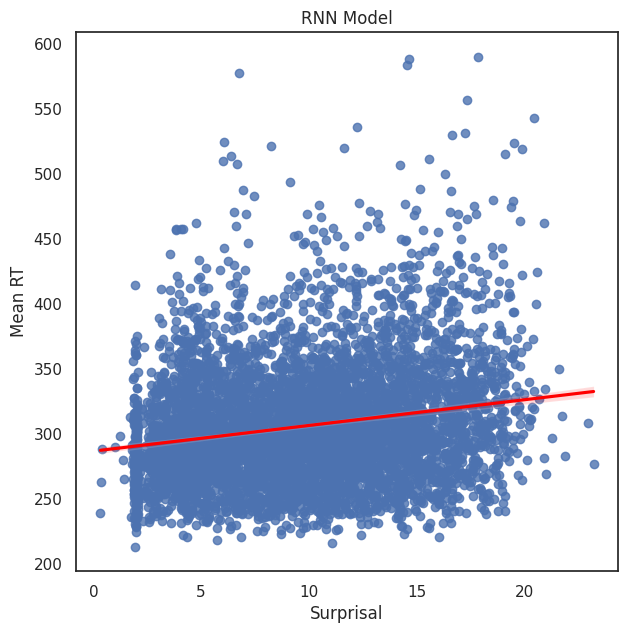

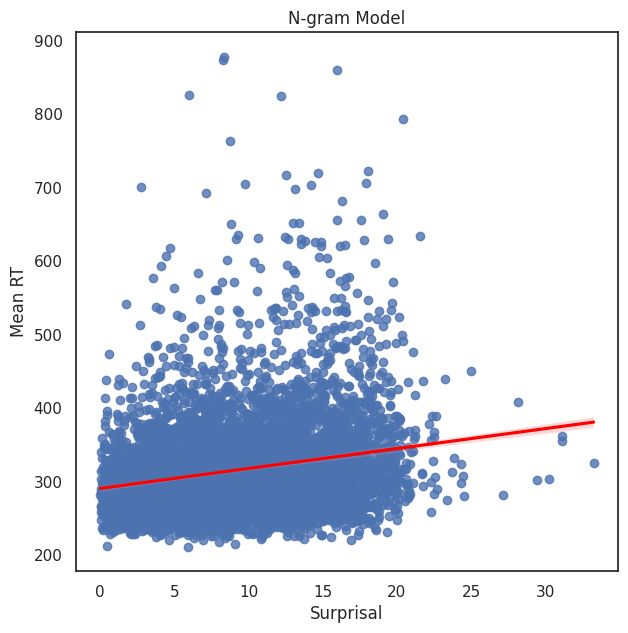

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", color_codes=True)

# First plot for the RNN data
plt.figure(figsize=(7, 7))
sns.regplot(x="rnn_surprisal", y="mean_rt", data=harmonized_df, line_kws={"color": "red"})
plt.title("RNN Model")
plt.xlabel("Surprisal")
plt.ylabel("Mean RT")
plt.show()

# Second plot for the N-gram data
plt.figure(figsize=(7, 7))
sns.regplot(x="surprisal", y="time", data=n_gram_wiki, line_kws={"color": "red"})
plt.title("N-gram Model")
plt.xlabel("Surprisal")
plt.ylabel("Mean RT")
plt.show()


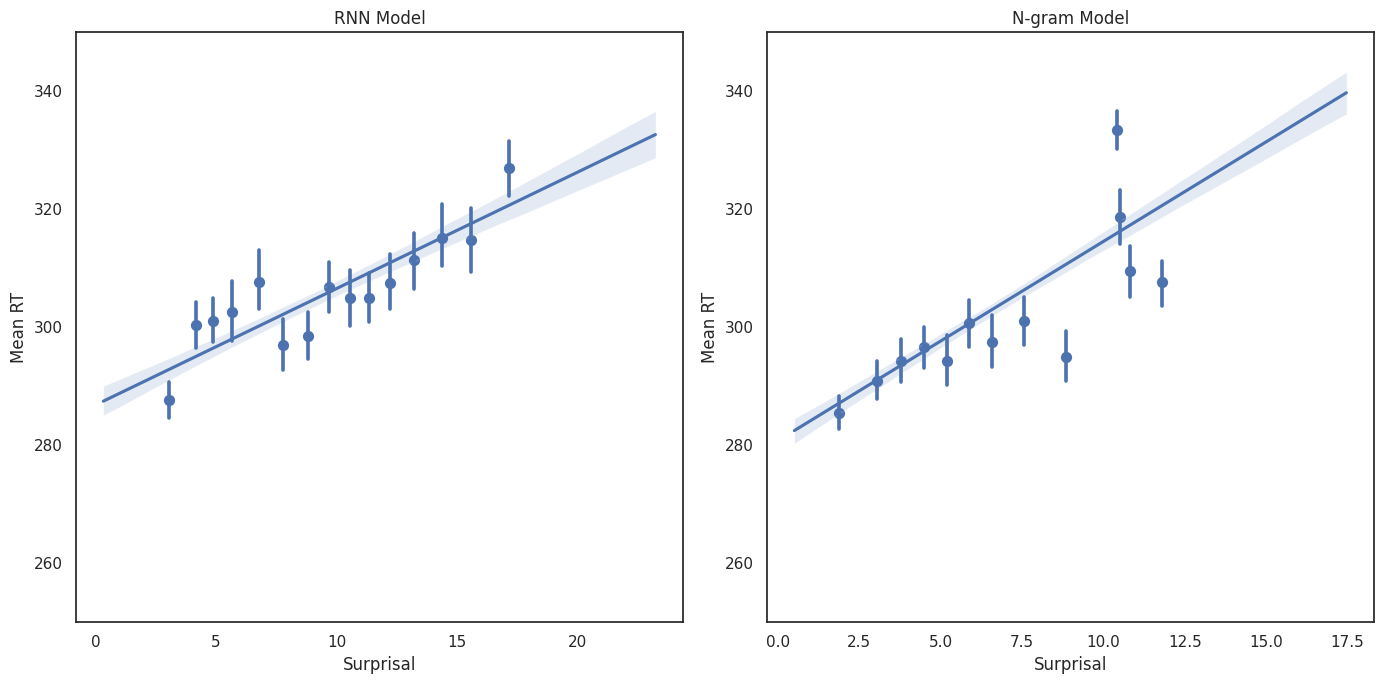

In [ ]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

# First plot for the RNN data with x_bins=15 and y-axis limit [250, 350]
sns.regplot(x="rnn_surprisal", y="mean_rt", data=harmonized_df, x_bins=15, ax=ax1)
ax1.set_ylim([250, 350])
ax1.set_title("RNN Model")
ax1.set_xlabel("Surprisal")
ax1.set_ylabel("Mean RT")

# Second plot for the N-gram data with x_bins=15 and y-axis limit [250, 350]
sns.regplot(x="n_gram_surprisal", y="mean_rt", data=harmonized_df, x_bins=15, ax=ax2)
ax2.set_ylim([250, 350])
ax2.set_title("N-gram Model")
ax2.set_xlabel("Surprisal")
ax2.set_ylabel("Mean RT")

# Tight layout to avoid overlap
plt.tight_layout()

## Different corpus - Task 2

In [ ]:
import pandas as pd

# Specify the correct headers
headers = ['subj_nr', 'sent_nr', 'sent_pos', 'correct', 'correct_answer_time', 'word_pos', 'word', 'RT']

# Read the space-separated file
df = pd.read_csv('selfpacedreadingRT.txt', sep='\t', names=headers, skiprows=1)

# Step 1: Group by 'sent_nr' and 'word' and calculate the mean of 'RT'
grouped_df = df.groupby(['sent_nr', 'word'], as_index=False).agg({'RT': 'mean'})

# Step 2: Merge the aggregated results back with the original DataFrame to retain original index
merged_df = pd.merge(df, grouped_df, on=['sent_nr', 'word'], suffixes=('', '_mean'))

# Step 3: Drop duplicates to avoid repeated rows after merging, if needed
merged_df = merged_df.drop_duplicates(subset=['sent_nr', 'word']).reset_index(drop=True)

# Step 4: Sort by the original index
merged_df = merged_df.sort_index()

# Display the result
print(merged_df[['sent_nr', 'word', 'RT_mean']])




      sent_nr       word     RT_mean
0           2      Billy  317.766234
1           2      wrote  316.688312
2           2         on  274.441558
3           2        the  245.909091
4           2  envelope.  273.792208
...       ...        ...         ...
4587      329        him  271.789474
4588      329       hill  275.184211
4589      329    without  290.776316
4590      329          a  277.000000
4591      329    jacket.  340.789474

[4592 rows x 3 columns]


## GAM - Task 1

Without binning

In [ ]:
rnn_surprisals = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/surprisals/rnn_surprisals.csv')
n_gram_surprisals = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/surprisals/n_gram_surprisals.csv')

<ipython-input-43-46efc471dd29>:46: RuntimeWarning: Mean of empty slice.
  binned_predictions = [model.predict(X)[bin_indices == i].mean() for i in range(1, len(bins))]
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


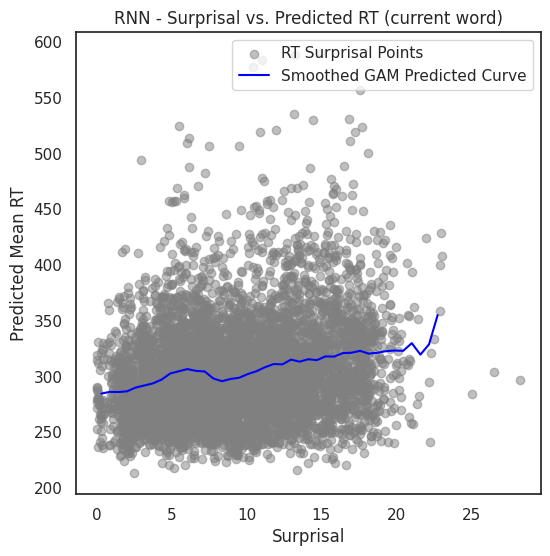

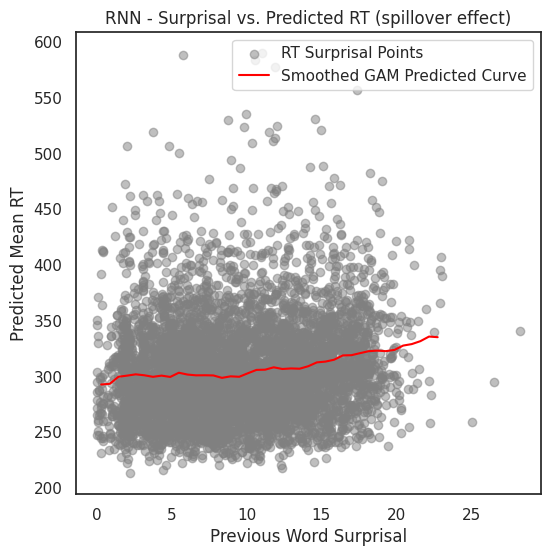

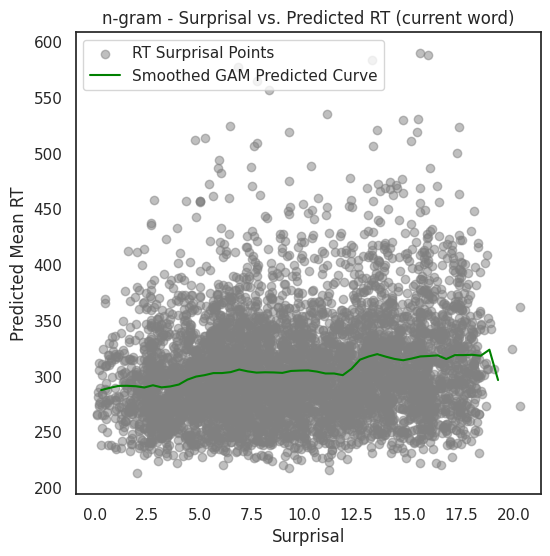

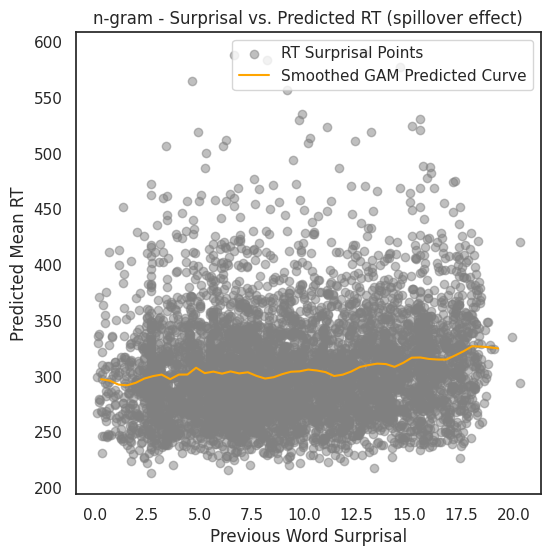

In [ ]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, l
import matplotlib.pyplot as plt

# Assuming rnn_gam and n_gram_surprisals are your DataFrames
rnn_gam = rnn_surprisals.copy()
n_gram_gam = n_gram_surprisals.copy()

# Calculate the frequency of each word for both dataframes
rnn_gam['frequency'] = rnn_gam.groupby('word')['word'].transform('count')
n_gram_gam['frequency'] = n_gram_gam.groupby('word')['word'].transform('count')
n_gram_gam['wlen'] = n_gram_gam['word'].apply(len)

# Calculate log-frequency
rnn_gam['log_frequency'] = np.log(rnn_gam['frequency'] + 1)
n_gram_gam['log_frequency'] = np.log(n_gram_gam['frequency'] + 1)

# Create the prev_surprisal column for both dataframes
rnn_gam['prev_surprisal'] = rnn_gam['surprisal'].shift(1)
n_gram_gam['prev_surprisal'] = n_gram_gam['surprisal'].shift(1)

# Drop any rows with NaN values resulting from the shift
rnn_gam = rnn_gam.dropna()
n_gram_gam = n_gram_gam.dropna()

# Prepare the feature matrix X and response variable y for both models
X_rnn = rnn_gam[['log_frequency', 'wlen', 'surprisal', 'prev_surprisal']].to_numpy()
y_rnn = rnn_gam['mean_rt'].values

X_ngram = n_gram_gam[['log_frequency', 'wlen', 'surprisal', 'prev_surprisal']].to_numpy()
y_ngram = n_gram_gam['mean_rt'].values

# Fit the GAM models for both current word probability (surprisal) and spillover effect (prev_surprisal)
gam_current_rnn = LinearGAM(s(2) + s(0) + s(1)).fit(X_rnn, y_rnn)
gam_spillover_rnn = LinearGAM(s(3) + s(0) + s(1)).fit(X_rnn, y_rnn)

gam_current_ngram = LinearGAM(s(2) + s(0) + s(1)).fit(X_ngram, y_ngram)
gam_spillover_ngram = LinearGAM(s(3) + s(0) + s(1)).fit(X_ngram, y_ngram)

# Function to plot smoothed GAM predictions
def plot_smoothed_predictions(X, y, model, x_variable, title, xlabel, ylabel, color='blue'):
    bins = np.linspace(X[:, x_variable].min(), X[:, x_variable].max(), 50)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_indices = np.digitize(X[:, x_variable], bins)
    binned_predictions = [model.predict(X)[bin_indices == i].mean() for i in range(1, len(bins))]

    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, x_variable], y, color='gray', alpha=0.5, label='RT Surprisal Points')
    plt.plot(bin_centers, binned_predictions, label=f'Smoothed GAM Predicted Curve', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot for current word probability (surprisal) - RNN
plot_smoothed_predictions(X_rnn, y_rnn, gam_current_rnn, 2,
                          "RNN - Surprisal vs. Predicted RT (current word)",
                          "Surprisal", "Predicted Mean RT", color='blue')

# Plot for spillover effect (prev_surprisal) - RNN
plot_smoothed_predictions(X_rnn, y_rnn, gam_spillover_rnn, 3,
                          "RNN - Surprisal vs. Predicted RT (spillover effect)",
                          "Previous Word Surprisal", "Predicted Mean RT", color='red')

# Plot for current word probability (surprisal) - n-gram
plot_smoothed_predictions(X_ngram, y_ngram, gam_current_ngram, 2,
                          "n-gram - Surprisal vs. Predicted RT (current word)",
                          "Surprisal", "Predicted Mean RT", color='green')

# Plot for spillover effect (prev_surprisal) - n-gram
plot_smoothed_predictions(X_ngram, y_ngram, gam_spillover_ngram, 3,
                          "n-gram - Surprisal vs. Predicted RT (spillover effect)",
                          "Previous Word Surprisal", "Predicted Mean RT", color='orange')


In [ ]:
print("RNN Model (Current Word) Coefficients:")
print(gam_current_rnn.coef_)

print("RNN Model (Spillover Effect) Coefficients:")
print(gam_spillover_rnn.coef_)

print("n-gram Model (Current Word) Coefficients:")
print(gam_current_ngram.coef_)

print("n-gram Model (Spillover Effect) Coefficients:")
print(gam_spillover_ngram.coef_)

print("RNN Model (Current Word) Summary:")
gam_current_rnn.summary()

print("RNN Model (Spillover Effect) Summary:")
gam_spillover_rnn.summary()

print("n-gram Model (Current Word) Summary:")
gam_current_ngram.summary()

print("n-gram Model (Spillover Effect) Summary:")
gam_spillover_ngram.summary()

RNN Model (Current Word) Coefficients:
[-34.49981707 -13.69983732 -12.8493487   -3.00819059   6.45620916
  18.18330007   0.73031555  11.48737483  18.91357327  23.07757304
  18.73912892  30.18183888  21.15530778  30.60676407  33.02807285
  61.9782401   46.04207026  23.28974435   9.91316119  -1.43333639
  14.13048199   5.93918018   0.81922271   7.14934453   0.81132463
  17.51808572  -6.99361445  12.62397502  25.70685312  10.90119904
  18.14284295  25.81958088  11.39861823  11.19816262  16.80333895
  27.87073598  25.5501789   16.82241056  20.29000491  25.79015936
 -45.39875108 -26.56703915 -10.56993533  -9.36706225 -14.47528026
 -11.75641526  -3.58006164  -5.35402329  -0.99085901  12.13535166
  13.74642754  10.114354     9.83427347  21.38665364  46.01734908
  65.9098032   51.99446577  37.32731237  59.30771184  88.57789115
 288.29216814]
RNN Model (Spillover Effect) Coefficients:
[-4.45896643e+00 -3.93895279e+00 -1.69123916e+00  5.90386120e-01
  1.46228148e+00  6.99796582e+00 -1.95262933e+

<ipython-input-44-ebfaa7b92e1a>:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_current_rnn.summary()
<ipython-input-44-ebfaa7b92e1a>:17: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_spillover_rnn.summary()
<ipython-input-44-ebfaa7b92e1a>:20: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_current_ngram.summary()
<ipython-input-44-ebfaa7b92e1a>:23: UserWarning: KNOWN BU

With binning

In [ ]:
rnn_surprisals = pd.read_csv('rnn_surprisals.csv')
n_gram_surprisals = pd.read_csv('n_gram_surprisals.csv')

<ipython-input-16-c0a3cc2dd424>:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rnn_binned_current = rnn_gam.groupby('surprisal_bin').agg({'surprisal': 'mean', 'mean_rt': ['mean', 'sem']})
<ipython-input-16-c0a3cc2dd424>:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rnn_binned_spillover = rnn_gam.groupby('prev_surprisal_bin').agg({'prev_surprisal': 'mean', 'mean_rt': ['mean', 'sem']})
<ipython-input-16-c0a3cc2dd424>:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a

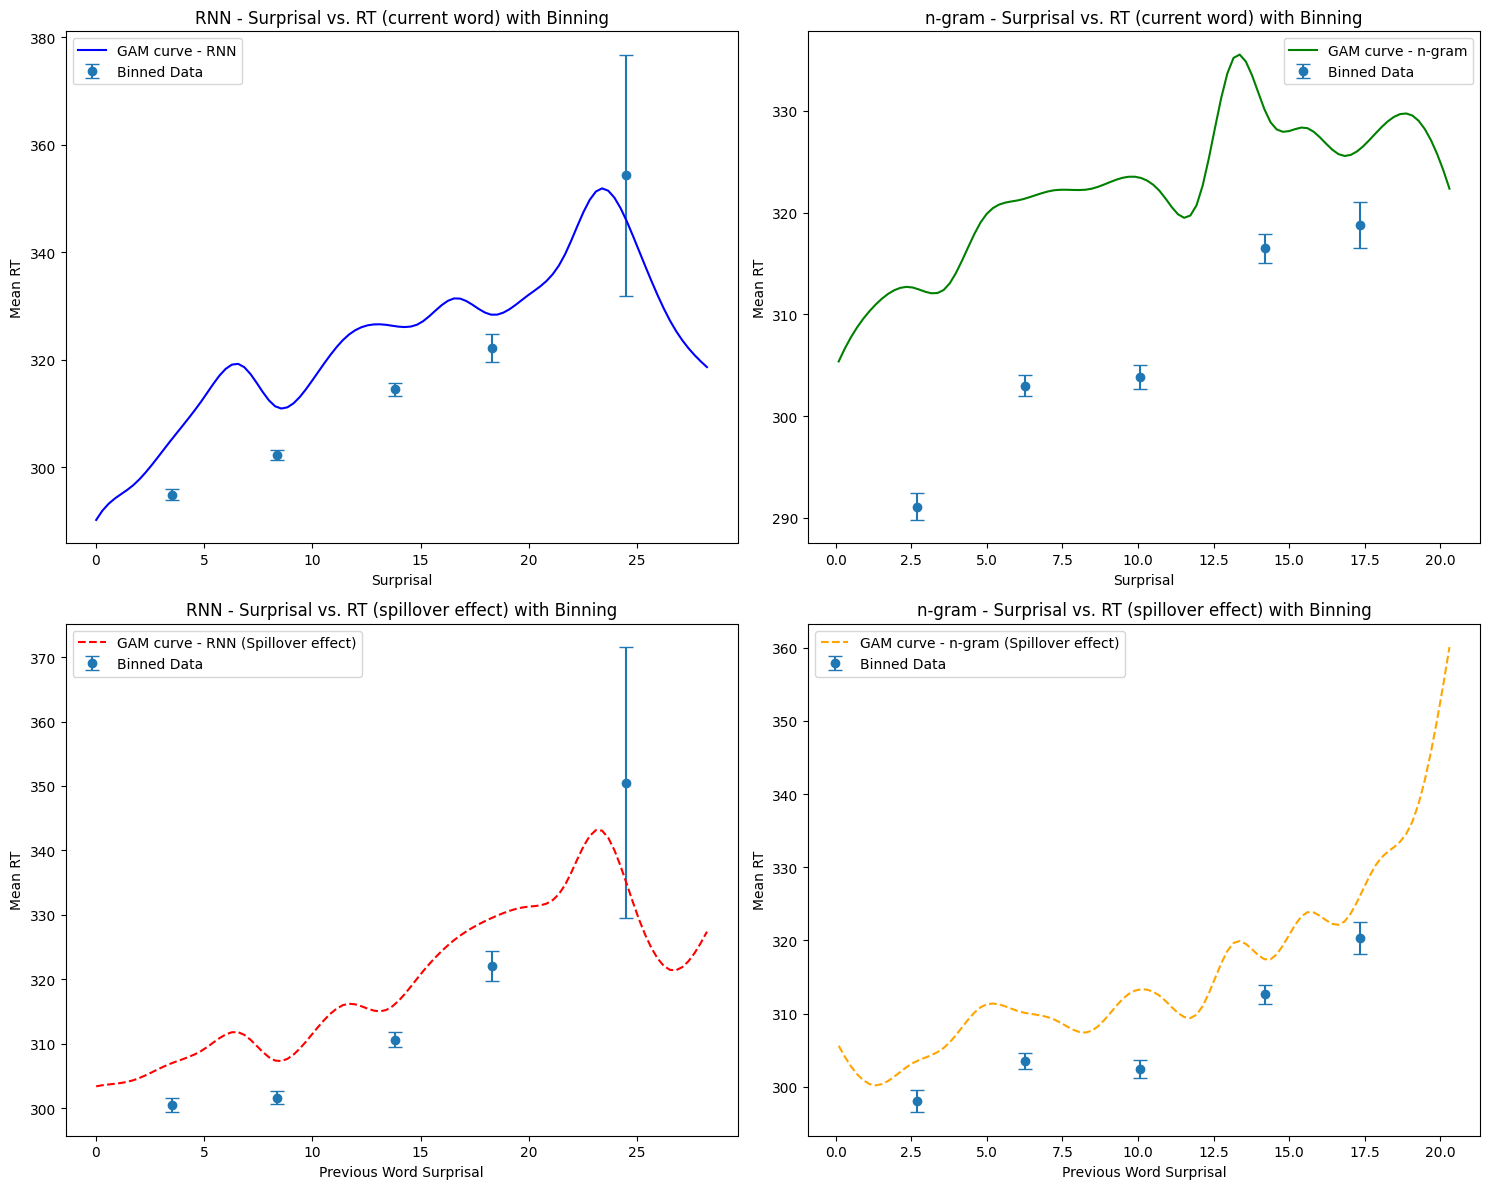

In [ ]:
! pip install pygam

import numpy as np
import pandas as pd
from pygam import LinearGAM, s
import matplotlib.pyplot as plt

# Assuming rnn_gam and n_gram_surprisals are your DataFrames
rnn_gam = rnn_surprisals.copy()
n_gram_gam = n_gram_surprisals.copy()

# Calculate the frequency of each word for both dataframes
rnn_gam['frequency'] = rnn_gam.groupby('word')['word'].transform('count')
n_gram_gam['frequency'] = n_gram_gam.groupby('word')['word'].transform('count')
n_gram_gam['wlen'] = n_gram_gam['word'].apply(len)

# Calculate log-frequency
rnn_gam['log_frequency'] = np.log(rnn_gam['frequency'] + 1)
n_gram_gam['log_frequency'] = np.log(n_gram_gam['frequency'] + 1)

# Create the prev_prob column for both dataframes
rnn_gam['prev_surprisal'] = rnn_gam['surprisal'].shift(1)
n_gram_gam['prev_surprisal'] = n_gram_gam['surprisal'].shift(1)

# Drop any rows with NaN values resulting from the shift
rnn_gam = rnn_gam.dropna()
n_gram_gam = n_gram_gam.dropna()

# Prepare the feature matrix X and response variable y for both models
X_rnn = rnn_gam[['log_frequency', 'wlen', 'surprisal', 'prev_surprisal']].to_numpy()
y_rnn = rnn_gam['mean_rt'].values

X_ngram = n_gram_gam[['log_frequency', 'wlen', 'surprisal', 'prev_surprisal']].to_numpy()
y_ngram = n_gram_gam['mean_rt'].values

# Fit the GAM models for both current word probability (prob) and spillover effect (prev_prob)
gam_current_rnn = LinearGAM(s(2) + s(0) + s(1) + s(3)).fit(X_rnn, y_rnn)
gam_spillover_rnn = LinearGAM(s(3) + s(0) + s(1) + s(2)).fit(X_rnn, y_rnn)

gam_current_ngram = LinearGAM(s(2) + s(0) + s(1) + s(3)).fit(X_ngram, y_ngram)
gam_spillover_ngram = LinearGAM(s(3) + s(0) + s(1) + s(2)).fit(X_ngram, y_ngram)

# Calculate the mean of the response variable (y)
mean_y_rnn = np.mean(y_rnn)
mean_y_ngram = np.mean(y_ngram)

# Binning the data
rnn_gam['surprisal_bin'] = pd.cut(rnn_gam['surprisal'], bins=5)
n_gram_gam['surprisal_bin'] = pd.cut(n_gram_gam['surprisal'], bins=5)
rnn_gam['prev_surprisal_bin'] = pd.cut(rnn_gam['prev_surprisal'], bins=5)
n_gram_gam['prev_surprisal_bin'] = pd.cut(n_gram_gam['prev_surprisal'], bins=5)

# Calculate mean and standard error for each bin
rnn_binned_current = rnn_gam.groupby('surprisal_bin').agg({'surprisal': 'mean', 'mean_rt': ['mean', 'sem']})
rnn_binned_spillover = rnn_gam.groupby('prev_surprisal_bin').agg({'prev_surprisal': 'mean', 'mean_rt': ['mean', 'sem']})

n_gram_binned_current = n_gram_gam.groupby('surprisal_bin').agg({'surprisal': 'mean', 'mean_rt': ['mean', 'sem']})
n_gram_binned_spillover = n_gram_gam.groupby('prev_surprisal_bin').agg({'prev_surprisal': 'mean', 'mean_rt': ['mean', 'sem']})

# Extract mean and sem for plotting
rnn_means_current = rnn_binned_current['mean_rt']['mean']
rnn_sems_current = rnn_binned_current['mean_rt']['sem']
rnn_surprisal_means = rnn_binned_current['surprisal']

rnn_means_spillover = rnn_binned_spillover['mean_rt']['mean']
rnn_sems_spillover = rnn_binned_spillover['mean_rt']['sem']
rnn_prev_surprisal_means = rnn_binned_spillover['prev_surprisal']

n_gram_means_current = n_gram_binned_current['mean_rt']['mean']
n_gram_sems_current = n_gram_binned_current['mean_rt']['sem']
n_gram_surprisal_means = n_gram_binned_current['surprisal']

n_gram_means_spillover = n_gram_binned_spillover['mean_rt']['mean']
n_gram_sems_spillover = n_gram_binned_spillover['mean_rt']['sem']
n_gram_prev_surprisal_means = n_gram_binned_spillover['prev_surprisal']

# Create the subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot for current word probability with binning - RNN
axs[0, 0].errorbar(rnn_surprisal_means, rnn_means_current, yerr=rnn_sems_current, fmt='o', capsize=5, label='Binned Data')
XX_current_rnn = gam_current_rnn.generate_X_grid(term=0)
axs[0, 0].plot(XX_current_rnn[:, 2], gam_current_rnn.partial_dependence(term=0, X=XX_current_rnn) + mean_y_rnn, label='GAM curve - RNN', color='blue')
axs[0, 0].set_title("RNN - Surprisal vs. RT (current word) with Binning")
axs[0, 0].set_xlabel("Surprisal")
axs[0, 0].set_ylabel("Mean RT")
axs[0, 0].legend()

# Plot for spillover effect with binning - RNN
axs[1, 0].errorbar(rnn_prev_surprisal_means, rnn_means_spillover, yerr=rnn_sems_spillover, fmt='o', capsize=5, label='Binned Data')
XX_spillover_rnn = gam_spillover_rnn.generate_X_grid(term=0)
axs[1, 0].plot(XX_spillover_rnn[:, 3], gam_spillover_rnn.partial_dependence(term=0, X=XX_spillover_rnn) + mean_y_rnn, label='GAM curve - RNN (Spillover effect)', linestyle='--', color='red')
axs[1, 0].set_title("RNN - Surprisal vs. RT (spillover effect) with Binning")
axs[1, 0].set_xlabel("Previous Word Surprisal")
axs[1, 0].set_ylabel("Mean RT")
axs[1, 0].legend()

# Plot for current word probability with binning - n-gram
axs[0, 1].errorbar(n_gram_surprisal_means, n_gram_means_current, yerr=n_gram_sems_current, fmt='o', capsize=5, label='Binned Data')
XX_current_ngram = gam_current_ngram.generate_X_grid(term=0)
axs[0, 1].plot(XX_current_ngram[:, 2], gam_current_ngram.partial_dependence(term=0, X=XX_current_ngram) + mean_y_ngram, label='GAM curve - n-gram', color='green')
axs[0, 1].set_title("n-gram - Surprisal vs. RT (current word) with Binning")
axs[0, 1].set_xlabel("Surprisal")
axs[0, 1].set_ylabel("Mean RT")
axs[0, 1].legend()

# Plot for spillover effect with binning - n-gram
axs[1, 1].errorbar(n_gram_prev_surprisal_means, n_gram_means_spillover, yerr=n_gram_sems_spillover, fmt='o', capsize=5, label='Binned Data')
XX_spillover_ngram = gam_spillover_ngram.generate_X_grid(term=0)
axs[1, 1].plot(XX_spillover_ngram[:, 3], gam_spillover_ngram.partial_dependence(term=0, X=XX_spillover_ngram) + mean_y_ngram, label='GAM curve - n-gram (Spillover effect)', linestyle='--', color='orange')
axs[1, 1].set_title("n-gram - Surprisal vs. RT (spillover effect) with Binning")
axs[1, 1].set_xlabel("Previous Word Surprisal")
axs[1, 1].set_ylabel("Mean RT")
axs[1, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# Open-Ended Task

## Obtaining surprisals for novel reading

In [ ]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your termin

In [ ]:
import re
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Load the dataset
ds = load_dataset("wikimedia/wikipedia", "20231101.nds-nl")

# Split into train and val
entire_list = list(range(len(ds['train'])))
print(len(entire_list))

Generating train split:   0%|          | 0/7847 [00:00<?, ? examples/s]

7847


Traning RNN on Dutch Wikipedia

In [ ]:
import re
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Load the dataset
ds = load_dataset("wikimedia/wikipedia", "20231101.nds-nl")

# Split into train and val
entire_list = list(range(len(ds['train'])))
train_indices, test_indices = train_test_split(entire_list, test_size=0.2, random_state=42)

def split_punctuation(text):
    # Add space before punctuation attached to a word
    text = re.sub(r"(?<=[a-zA-Z])(?=[^\w\s])", r" ", text)
    # Add space after punctuation attached to a word
    text = re.sub(r"(?<=[^\w\s])(?=[a-zA-Z])", r" ", text)
    return text

# combine all texts into one and add the title before each text ---- TRAIN
combined_text = ""
for i in train_indices:
    text = ds['train'][i]['text']
    lines = text.split("\n")
    fixed_text = split_punctuation("\n".join(lines))
    combined_text += f"{fixed_text}\n"

# save the combined text to a file
with open("wiki_dutch_train.txt", "w") as f:
    f.write(combined_text)

# combine all texts into one and add the title before each text ---- VAL
combined_text = ""
for i in test_indices:
    text = ds['train'][i]['text']
    lines = text.split("\n")
    fixed_text = split_punctuation("\n".join(lines))
    combined_text += f"{fixed_text}\n"

# save the combined text to a file
with open("wiki_dutch_val.txt", "w") as f:
    f.write(combined_text)

Training RNN on Dutch Wiki

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/wiki_dutch_rnn.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/wiki_dutch_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/wiki_dutch_frames" --trainfname wiki_dutch_train.txt --validfname wiki_dutch_val.txt

Libraries loaded
| epoch   1 |   200/ 2917 batches | lr 20.00 | ms/batch 79.35 | loss  7.98 | ppl  2923.60
| epoch   1 |   400/ 2917 batches | lr 20.00 | ms/batch 76.96 | loss  7.15 | ppl  1278.74
| epoch   1 |   600/ 2917 batches | lr 20.00 | ms/batch 78.72 | loss  7.07 | ppl  1181.84
| epoch   1 |   800/ 2917 batches | lr 20.00 | ms/batch 80.65 | loss  7.00 | ppl  1099.59
| epoch   1 |  1000/ 2917 batches | lr 20.00 | ms/batch 82.60 | loss  6.97 | ppl  1059.66
| epoch   1 |  1200/ 2917 batches | lr 20.00 | ms/batch 85.04 | loss  6.91 | ppl  1003.64
| epoch   1 |  1400/ 2917 batches | lr 20.00 | ms/batch 88.05 | loss  6.87 | ppl   963.45
| epoch   1 |  1600/ 2917 batches | lr 20.00 | ms/batch 86.90 | loss  6.89 | ppl   978.16
| epoch   1 |  1800/ 2917 batches | lr 20.00 | ms/batch 85.26 | loss  6.85 | ppl   944.52
| epoch   1 |  2000/ 2917 batches | lr 20.00 | ms/batch 84.97 | loss  6.84 | ppl   932.47
| epoch   1 |  2200/ 2917 batches | lr 20.00 | ms/batch 85.75 | loss  6.91 | ppl  1

Obtaining surprisals for L1

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/wiki_dutch_frames/wiki_dutch_rnn.pt" \
    --vocab_file "$GDRIVE_DIR/wiki_dutch_frames/wiki_dutch_vocab.txt" --data_dir "$GDRIVE_DIR/wiki_dutch_frames" \
    --testfname 'L1.txt' --test --words --nopp > "$GDRIVE_DIR/wiki_dutch_frames/rnn_wiki_dutch_surprisals.tsv"

Libraries loaded
Using beamsize: 189079


In [ ]:
rnn_wiki = pd.read_csv("/content/rnn_wiki_dutch_surprisals - rnn_wiki_dutch_surprisals.tsv", sep=' ')
rnn_wiki.head()

word  sentid  sentpos  wlen       surp    entropy    entred
0              De       0        0     2   4.718139  13.723593  0.000000
1          enorme       0        1     6  16.552916  13.726727  0.000000
2  belangstelling       0        2    14  12.872829  13.533494  0.193233
3             die       0        3     3   8.031992   9.085464  4.448030
4             het       0        4     3   9.582423   9.846126  0.000000

Training RNN on English Wiki

In [ ]:
! pip install datasets

from datasets import load_dataset
from sklearn.model_selection import train_test_split
import re

ds = load_dataset("wikimedia/wikipedia", "20231101.en")

entire_list = list(range(len(ds['train'])))
# only pick
print(len(entire_list))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6407814 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]

6407814


In [ ]:
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import re

ds = load_dataset("wikimedia/wikipedia", "20231101.en")

entire_list = list(range(len(ds['train'])))

# only pick 10000 indexes from the entire list
entire_list = np.random.choice(entire_list, size=10000, replace=False)
train_indices, test_indices = train_test_split(entire_list, test_size=0.2, random_state=42)

def split_punctuation(text):
    # Add space before punctuation attached to a word
    text = re.sub(r"(?<=[a-zA-Z])(?=[^\w\s])", r" ", text)
    # Add space after punctuation attached to a word
    text = re.sub(r"(?<=[^\w\s])(?=[a-zA-Z])", r" ", text)
    return text

# combine all texts into one and add the title before each text ---- TRAIN
combined_text = ""
for i in train_indices:
    text = ds['train'][int(i)]['text']
    lines = text.split("\n")
    fixed_text = split_punctuation("\n".join(lines))
    combined_text += f"{fixed_text}\n"

# save the combined text to a file
with open("wiki_english_train.txt", "w") as f:
    f.write(combined_text)

# combine all texts into one and add the title before each text ---- VAL
combined_text = ""
for i in test_indices:
    text = ds['train'][int(i)]['text']
    lines = text.split("\n")
    fixed_text = split_punctuation("\n".join(lines))
    combined_text += f"{fixed_text}\n"

# save the combined text to a file
with open("wiki_english_val.txt", "w") as f:
    f.write(combined_text)

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/wiki_english_rnn.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/wiki_english_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/wiki_english_frames" --trainfname wiki_english_train.txt --validfname wiki_english_val.txt

Libraries loaded
| epoch   1 |   200/ 6965 batches | lr 20.00 | ms/batch 59.81 | loss  9.48 | ppl 13129.41
| epoch   1 |   400/ 6965 batches | lr 20.00 | ms/batch 53.32 | loss  7.34 | ppl  1547.30
| epoch   1 |   600/ 6965 batches | lr 20.00 | ms/batch 53.64 | loss  7.16 | ppl  1281.40
| epoch   1 |   800/ 6965 batches | lr 20.00 | ms/batch 53.87 | loss  6.73 | ppl   835.13
| epoch   1 |  1000/ 6965 batches | lr 20.00 | ms/batch 54.25 | loss  6.63 | ppl   756.06
| epoch   1 |  1200/ 6965 batches | lr 20.00 | ms/batch 54.70 | loss  6.83 | ppl   922.34
| epoch   1 |  1400/ 6965 batches | lr 20.00 | ms/batch 55.07 | loss  6.89 | ppl   980.12
| epoch   1 |  1600/ 6965 batches | lr 20.00 | ms/batch 55.55 | loss  6.81 | ppl   907.19
| epoch   1 |  1800/ 6965 batches | lr 20.00 | ms/batch 55.50 | loss  6.85 | ppl   940.16
| epoch   1 |  2000/ 6965 batches | lr 20.00 | ms/batch 55.09 | loss  7.00 | ppl  1097.66
| epoch   1 |  2200/ 6965 batches | lr 20.00 | ms/batch 54.86 | loss  7.03 | ppl  1

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/wiki_english_rnn.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/wiki_english_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/wiki_english_frames" \
    --trainfname wiki_english_train.txt --validfname wiki_english_val.txt \
    --load_checkpoint


Libraries loaded
  Continuing training from previous checkpoint
| epoch   1 |   200/ 6965 batches | lr 20.00 | ms/batch 60.60 | loss  6.78 | ppl   875.98
| epoch   1 |   400/ 6965 batches | lr 20.00 | ms/batch 53.45 | loss  6.79 | ppl   888.24
| epoch   1 |   600/ 6965 batches | lr 20.00 | ms/batch 53.73 | loss  6.89 | ppl   981.11
| epoch   1 |   800/ 6965 batches | lr 20.00 | ms/batch 54.09 | loss  6.62 | ppl   746.91
| epoch   1 |  1000/ 6965 batches | lr 20.00 | ms/batch 54.52 | loss  6.60 | ppl   732.15
| epoch   1 |  1200/ 6965 batches | lr 20.00 | ms/batch 54.65 | loss  6.81 | ppl   908.68
| epoch   1 |  1400/ 6965 batches | lr 20.00 | ms/batch 54.87 | loss  6.86 | ppl   954.35
| epoch   1 |  1600/ 6965 batches | lr 20.00 | ms/batch 55.24 | loss  6.80 | ppl   901.90
| epoch   1 |  1800/ 6965 batches | lr 20.00 | ms/batch 55.71 | loss  6.83 | ppl   920.79
| epoch   1 |  2000/ 6965 batches | lr 20.00 | ms/batch 55.84 | loss  6.96 | ppl  1052.67
| epoch   1 |  2200/ 6965 batches | 

Obtaining surprisals for L2 and Monolingual

In [ ]:
vocab_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wiki_english_frames/frames'
model_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wiki_english_frames/'

In [ ]:
!cd rnn && python main.py --model_file "$model_path/wiki_english_rnn.pt" \
    --vocab_file "$vocab_path/wiki_english_vocab.txt" --data_dir "$model_path" \
    --testfname 'English.txt' --test --words --nopp > "/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wiki_english_frames/rnn_wiki_english.tsv"

Libraries loaded
Using beamsize: 202982
Traceback (most recent call last):
  File "/content/rnn/main.py", line 658, in <module>
    test_loss = test_evaluate(test_sents, test_data)
  File "/content/rnn/main.py", line 465, in test_evaluate
    get_complexity(output_flat, targets, i)
  File "/content/rnn/main.py", line 311, in get_complexity
    Hs = torch.log2(torch.exp(torch.squeeze(apply(get_entropy, state))))
  File "/content/rnn/main.py", line 343, in apply
    output_list = [func(m) for m in torch.unbind(apply_dimension, dim=0)]
  File "/content/rnn/main.py", line 343, in <listcomp>
    output_list = [func(m) for m in torch.unbind(apply_dimension, dim=0)]
  File "/content/rnn/main.py", line 279, in get_entropy
    beamk, beamix = torch.topk(state, args.complexn, 0)
KeyboardInterrupt


In [ ]:
vocab_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wiki_dutch_frames/frames'
model_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wiki_dutch_frames/'

In [ ]:
!cd rnn && python main.py --cuda --model_file "$model_path/wiki_dutch_rnn.pt" \
    --vocab_file "$vocab_path/wiki_dutch_vocab.txt" --data_dir "$model_path" \
    --testfname 'L1_modified.txt' --test --words --nopp > "/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wiki_english_frames/rnn_wiki_english.tsv"

Libraries loaded
Using beamsize: 189079


In [ ]:
import pandas as pd

In [ ]:
rnn_english_wiki = pd.read_csv("/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/surprisals/rnn_english_wiki.csv", sep=',')
rnn_english_wiki.head()

Unnamed: 0      word  sentid  sentpos  wlen       surp    entropy    entred
0           0       The       0        0     3   5.175300  13.102895  0.000000
1           1   intense       0        1     7  15.440462  11.986347  1.116548
2           2  interest       0        2     8  14.434409  10.027184  1.959163
3           3   aroused       0        3     7  20.291452   8.961705  1.065479
4           4        in       0        4     2   4.221605   8.474387  0.487318

In [ ]:
rnn_english_mono_wiki = pd.read_csv("/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wiki_english_frames/rnn_wiki_english_surprisals_mono.tsv", sep=' ')
rnn_english_mono_wiki.to_csv('rnn_english_mono_wiki.csv')
rnn_english_mono_wiki.head()

word  sentid  sentpos  wlen       surp    entropy    entred
0       The       0        0     3   5.175316  13.102900  0.000000
1   intense       0        1     7  15.440454  11.986356  1.116544
2  interest       0        2     8  14.434424  10.027103  1.959252
3   aroused       0        3     7  20.291462   8.961824  1.065279
4        in       0        4     2   4.221601   8.474399  0.487426

In [ ]:
import csv
import pandas as pd
import sys

csv.field_size_limit(sys.maxsize)


# Initialize a list to hold cleaned rows
cleaned_rows = []

# Open the TSV file and process it line by line
with open("/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wiki_dutch_frames/rnn_wiki_dutch_surprisals_L1.tsv", 'r', encoding='utf-8') as file:
    reader = csv.reader(file, delimiter='\t')

    for row in reader:
        try:
            # Clean each row by removing problematic characters
            cleaned_row = [cell.replace('"', '') for cell in row]
            cleaned_rows.append(cleaned_row)
        except Exception as e:
            # If there's an issue with a row, print it and skip the row
            print(f"Error processing row {reader.line_num}: {e}")
            continue

# Convert the cleaned data to a pandas DataFrame
df = pd.DataFrame(cleaned_rows[1:], columns=cleaned_rows[0])  # Use first row as header

# Save the cleaned DataFrame to a new TSV file
df.to_csv('rnn_dutch_L1_wiki.csv', sep=',', index=False)


In [ ]:
rnn_dutch_L1_wiki = pd.read_csv(GDRIVE_DIR + "/open_ended_task/rnn_dutch_L1_wiki.csv", sep=',')
rnn_dutch_L1_wiki.head()

word  sentid  sentpos  wlen       surp    entropy    entred
0              De     0.0      0.0   2.0   4.718132  13.723577  0.000000
1          enorme     0.0      1.0   6.0  16.552916  13.726736  0.000000
2  belangstelling     0.0      2.0  14.0  12.872807  13.533368  0.193368
3             die     0.0      3.0   3.0   8.032214   9.085469  4.447899
4             het     0.0      4.0   3.0   9.582236   9.846535  0.000000

In [ ]:
# Save the DataFrames to CSV files in the specified Google Drive folder
rnn_english_L2_wiki.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/rnn_english_L2_wiki.csv', index=False)
rnn_english_mono_wiki.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/rnn_english_mono_wiki.csv', index=False)
rnn_dutch_L1_wiki.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/rnn_dutch_L1_wiki.csv', index=False)


## Obtaining RTs

Reading CSV files

In [ ]:
import pandas as pd

L1_RT = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/GECO/L1_RT.csv')
# df_L2 = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/GECO/L2_RT.csv')
# df_Mono = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/GECO/Mono_RT.csv')

print(L1_RT.head(10))
# print(df_L2.head())
# print(df_Mono.head())

              WORD WORD_GAZE_DURATION
0              De                 191
1          enorme                 227
2  belangstelling                 274
3             die                 107
4             het                 204
5         publiek                  95
6          toonde                 227
7            voor                   .
8             wat                 436
9       indertijd                 263


Harmonizing

In [ ]:
import pandas as pd
import math
import re
from collections import Counter

In [ ]:
L1_RNN = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/surprisals/rnn_dutch_L1_wiki.csv')
L1_RT = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/GECO/L1_RT.csv')

print(L1_RNN.head())
print(L1_RT.head())

             word  sentid  sentpos  wlen       surp    entropy    entred
0              De     0.0      0.0   2.0   4.718132  13.723577  0.000000
1          enorme     0.0      1.0   6.0  16.552916  13.726736  0.000000
2  belangstelling     0.0      2.0  14.0  12.872807  13.533368  0.193368
3             die     0.0      3.0   3.0   8.032214   9.085469  4.447899
4             het     0.0      4.0   3.0   9.582236   9.846535  0.000000
              WORD WORD_GAZE_DURATION WORD_AVERAGE_FIX_PUPIL_SIZE  WORD_SKIP
0              De                 191                        3401          0
1          enorme                 227                        2815          0
2  belangstelling                 274                        3210          0
3             die                 107                        3185          0
4             het                 204                        3301          1


In [ ]:
# Omitting repetitions
L1_RNN = L1_RNN.iloc[:15670]

In [ ]:
print(L1_RNN.iloc[-1])

word           <unk>
sentid        1387.0
sentpos         19.0
wlen             5.0
surp        21.07122
entropy    11.376176
entred           0.0
Name: 15669, dtype: object


In [ ]:
def harmonize_wiki(RT_df_orig, RNN_df_orig):
  RT_df = RT_df_orig.copy()
  RNN_df = RNN_df_orig.copy()
  rt_drop = []
  rnn_drop = []
  i = 0
  j = 0



  RNN_df.drop(2235, inplace=True)
  RNN_df.reset_index(drop=True, inplace=True)
  while i < len(RT_df) and j < len(RNN_df):

      if RNN_df.iloc[i]['word'] == "<unk>" or RT_df.iloc[j]['WORD_GAZE_DURATION'] == '.' or \
      RT_df.iloc[j]['WORD_AVERAGE_FIX_PUPIL_SIZE'] == '.':
          rt_drop.append(i)
          rnn_drop.append(j)
      i += 1
      j += 1

  RT_df.drop(rt_drop, inplace=True)
  RNN_df.drop(rnn_drop, inplace=True)

  # Reset the indices after dropping rows
  RT_df.reset_index(drop=True, inplace=True)
  RNN_df.reset_index(drop=True, inplace=True)
  print("------------After dropping <unk> and '.'----------------")

  # Iterate row by row of first and second df and stop when their columns 'word' and 'WORD' don't match
  i = 0
  j = 0
  while i < len(RT_df) and j < len(RNN_df):
    if RT_df.iloc[i]['WORD'].replace(' ', '') != RNN_df.iloc[j]['word']:
      print("THE INDICES OF MISMATCH ARE:")
      print(i, j)
      # print two words before and two words after for both dfs
      print("----------------RT----------------")
      print(RT_df.iloc[i-2:i+2]['WORD'])
      print("----------------RNN----------------")
      print(RNN_df.iloc[j-2:j+2]['word'])
      break
    i += 1
    j += 1

harmonize_wiki(L1_RT, L1_RNN)



------------After dropping <unk> and '.'----------------
THE INDICES OF MISMATCH ARE:
1488 1488
----------------RT----------------
1486    mevrouw 
1487       toon 
1488        het 
1489     meisje 
Name: WORD, dtype: object
----------------RNN----------------
1486    mevrouw
1487       toon
1488          ;
1489        het
Name: word, dtype: object


Adding log-frequency

In [ ]:
import pandas as pd
import math
import re
from collections import Counter

with open('L2_modified.txt', 'r', encoding='utf-8') as file:
    text = file.read().lower()  # Convert to lowercase for consistent counting

# Tokenize the text into words, removing punctuation
words = re.findall(r'\b\w+\b', text)

# Calculate the frequency of each word
word_freq = Counter(words)

def calculate_log_freq(word):
    frequency = word_freq.get(word, 0)
    return math.log10(frequency) if frequency > 0 else 0

df['LOG_FREQ'] = df['WORD'].apply(calculate_log_freq)

print(df)


## Analyzing correlation between suprisal and gaze duration

### Harmonizing

In [ ]:
import pandas as pd

In [ ]:
rnn_english_wiki = pd.read_csv("/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/surprisals/rnn_english_wiki.csv", sep=',')
rnn_english_wiki.head()

Unnamed: 0      word  sentid  sentpos  wlen       surp    entropy    entred
0           0       The       0        0     3   5.175300  13.102895  0.000000
1           1   intense       0        1     7  15.440462  11.986347  1.116548
2           2  interest       0        2     8  14.434409  10.027184  1.959163
3           3   aroused       0        3     7  20.291452   8.961705  1.065479
4           4        in       0        4     2   4.221605   8.474387  0.487318

In [ ]:
mono_RT = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/RT/Mono_RT.csv')
mono_RT.head()

Unnamed: 0 WORD_ID      WORD  WORD_GAZE_DURATION  \
0           0   1-5-1       The          226.692308   
1           1   1-5-2   intense          276.769231   
2           2   1-5-3  interest          293.384615   
3           3   1-5-4   aroused          217.642857   
4           4   1-5-5        in          171.428571   

   WORD_AVERAGE_FIX_PUPIL_SIZE  part  trial  word_number  diff  
0                  2684.346154     1    5.0          1.0   NaN  
1                  2666.653846     1    5.0          2.0   1.0  
2                  2601.705385     1    5.0          3.0   1.0  
3                  2665.047857     1    5.0          4.0   1.0  
4                  2883.357143     1    5.0          5.0   1.0

In [ ]:
l2_RT = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/RT/L2_RT.csv')
l2_RT.head()

WORD_ID      WORD  WORD_GAZE_DURATION  WORD_AVERAGE_FIX_PUPIL_SIZE  part  \
0   1-5-1       The          232.625000                  3344.875000     1   
1   1-5-2   intense          367.555556                  2985.463333     1   
2   1-5-3  interest          399.750000                  3126.453750     1   
3   1-5-4   aroused          327.444444                  2974.528889     1   
4   1-5-5        in          143.500000                  2924.000000     1   

   trial  word_number  diff  
0      5            1   NaN  
1      5            2   1.0  
2      5            3   1.0  
3      5            4   1.0  
4      5            5   1.0

In [ ]:
l1_RT = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/RT/L1_RT.csv')
l1_RT.head()

Unnamed: 0 WORD_ID            WORD  WORD_GAZE_DURATION  \
0           0   1-5-1              De          191.222222   
1           1   1-5-2          enorme          198.666667   
2           2   1-5-3  belangstelling          312.222222   
3           3   1-5-4             die          156.000000   
4           4   1-5-5             het          197.250000   

   WORD_AVERAGE_FIX_PUPIL_SIZE  part  trial  word_number  diff  
0                  2774.944444     1      5            1   NaN  
1                  2702.777778     1      5            2   1.0  
2                  2688.511111     1      5            3   1.0  
3                  2607.333333     1      5            4   1.0  
4                  2719.062500     1      5            5   1.0

In [ ]:
rnn_dutch_wiki = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/surprisals/rnn_dutch_wiki.csv')
rnn_dutch_wiki.head()

Unnamed: 0            word  sentid  sentpos  wlen       surp    entropy  \
0           0              De     0.0      0.0   2.0   4.718139  13.723593   
1           1          enorme     0.0      1.0   6.0  16.552916  13.726727   
2           2  belangstelling     0.0      2.0  14.0  12.872829  13.533494   
3           3             die     0.0      3.0   3.0   8.031992   9.085464   
4           4             het     0.0      4.0   3.0   9.582423   9.846126   

     entred  
0  0.000000  
1  0.000000  
2  0.193233  
3  4.448030  
4  0.000000

Harmonizing L2, Monolingual RTs and RNN English surprisals

In [ ]:
import math
import string

def harmonize_three_wiki(rnn, mono, L1):
  rnn_english = rnn.copy()
  Mono_RT = mono.copy()
  L1_RT = L1.copy()
  rnn_drop = []
  mono_drop = []
  l1_drop = []
  i = 0
  j = 0
  k = 0

  rnn_english.drop(6387, inplace=True)
  Mono_RT.drop(7733, inplace=True)
  rnn_english.drop(7757, inplace=True)
  rnn_english.reset_index(drop=True, inplace=True)
  Mono_RT.reset_index(drop=True, inplace=True)

  just_skipped = False
  while i < len(rnn_english) and j < len(Mono_RT) and k < len(L1_RT):
    print(f"---------------CURRENT WORD:-------------")
    print(f"RNN: {rnn_english.iloc[i]['word']}")
    print(f"Mono: {Mono_RT.iloc[j]['WORD'].replace(' ', '')}")
    print(f"L2: {L1_RT.iloc[k]['WORD'].replace(' ', '')}")

    word_mono = Mono_RT.iloc[j]['WORD'].replace(' ', '')
    word_mono = word_mono.translate(str.maketrans('', '', string.punctuation))
    word_l1 = L1_RT.iloc[k]['WORD'].replace(' ', '')
    word_l1 = word_l1.translate(str.maketrans('', '', string.punctuation))
    word_rnn = rnn_english.iloc[i]['word']

    all_words_match = (word_mono == word_l1 == word_rnn)

    skip_no = 1.0
    skip_no_mono = 1.0

    skip_no_l1 = L1_RT.iloc[k]['diff']
    skip_no_mono = Mono_RT.iloc[j]['diff']

    if rnn_english.iloc[i]['word'] == "<unk>" and word_mono == word_l1:
      print("MONO AND L2 ARE THE SAME")
      rnn_drop.append(i)
      mono_drop.append(j)
      l1_drop.append(k)
      i += 1
      j += 1
      k += 1
      continue

    if not all_words_match:

      if L1_RT.iloc[k]['diff'] != 1.0 and not math.isnan(L1_RT.iloc[k]['diff']) and not just_skipped and\
      Mono_RT.iloc[j]['diff'] != 1.0 and not math.isnan(Mono_RT.iloc[j]['diff']):
        just_skipped = True
        print(f"ENTERING AT INDEX {k} - BOTH")
        skip_no_l1 = L1_RT.iloc[k]['diff']
        skip_no_mono = Mono_RT.iloc[j]['diff']
        if skip_no_l1 == skip_no_mono:
          print("BOTH WORDS ARE THE SAME IN MONO AND L2")
          print(f"SKIPPING {skip_no_l1 - 1} INDICES FOR RNN")
          print(f"NEXT WORD FOR RNN IS:")
          print(rnn_english.iloc[i + int(skip_no_l1) - 1]['word'])
          for l in range(int(skip_no_l1) - 1):
            rnn_drop.append(i + l)
          i += int(skip_no_l1) - 1
        elif skip_no_l1 < skip_no_mono:
          print("MONO IS FURTHER")
          print(f"SKIPPING {skip_no_mono - 1} INDICES FOR RNN")
          for l in range(int(skip_no_mono) - 1):
            rnn_drop.append(i + l)
          i += int(skip_no_mono) - 1
          print(f"SKIPPING {skip_no_mono - skip_no_l1} INDICES FOR L2")
          for l in range(int(skip_no_mono - skip_no_l1)):
            l1_drop.append(k + l)
          k += int(skip_no_mono - skip_no_l1)
        elif skip_no_l1 > skip_no_mono:
          print("L2 IS FURTHER")
          print(f"SKIPPING {skip_no_l1 - 1} INDICES FOR RNN")
          for l in range(int(skip_no_l1) - 1):
            rnn_drop.append(i + l)
          i += int(skip_no_l1) - 1
          print(f"SKIPPING {skip_no_l1 - skip_no_mono} INDICES FOR MONO")
          for l in range(int(skip_no_l1 - skip_no_mono)):
            mono_drop.append(j + l)
          j += int(skip_no_l1 - skip_no_mono)
        continue

      if Mono_RT.iloc[j]['diff'] != 1.0 and not math.isnan(Mono_RT.iloc[j]['diff']) and not just_skipped:
        just_skipped = True
        print(f"ENTERING AT INDEX {j} - MONO")
        print(f"SKIPPING {skip_no - 1} INDICES FOR RNN AND L2")
        print(f"NEXT WORDS FOR BOTH ARE:")
        print(rnn_english.iloc[i + int(skip_no) - 1]['word'])
        print(L1_RT.iloc[k + int(skip_no) - 1]['WORD'].replace(' ', ''))
        skip_no = Mono_RT.iloc[j]['diff']
        for l in range(int(skip_no) - 1):
          rnn_drop.append(i + l)
          l1_drop.append(k + l)
        i += int(skip_no) - 1
        k += int(skip_no) - 1
        continue
      if L1_RT.iloc[k]['diff'] != 1.0 and not math.isnan(L1_RT.iloc[k]['diff']) and not just_skipped:
        just_skipped = True
        print(f"ENTERING AT INDEX {k} - L2")
        skip_no = L1_RT.iloc[k]['diff']
        print(f"SKIPPING {skip_no - 1} INDICES FOR RNN AND MONO")
        print(f"NEXT WORDS FOR BOTH ARE:")
        print(rnn_english.iloc[i + int(skip_no) - 1]['word'])
        print(Mono_RT.iloc[j + int(skip_no) - 1]['WORD'].replace(' ', ''))
        for l in range(int(skip_no) - 1):
          rnn_drop.append(i + l)
          mono_drop.append(j + l)
        i += int(skip_no) - 1
        j += int(skip_no) - 1
        continue

    just_skipped = False

    # if words do not match stop
    if (rnn_english.iloc[i]['word'] != Mono_RT.iloc[j]['WORD'].replace(' ', '') or rnn_english.iloc[i]['word'] != L1_RT.iloc[k]['WORD'].replace(' ', '')) and \
    rnn_english_wiki.iloc[i]['word'] != '<unk>':
      print("STOPPING")
      print(f"---------------CURRENT WORD:-------------")
      print(f"RNN: {rnn_english.iloc[i]['word']}")
      print(f"Mono: {Mono_RT.iloc[j]['WORD'].replace(' ', '')}")
      print(f"L1: {L1_RT.iloc[k]['WORD'].replace(' ', '')}")
      print("THE INDICES OF MISMATCH ARE:")
      print(i, j, k)
      break

    i += 1
    j += 1
    k += 1



  print()
  print()
  print()



  rnn_english.drop(rnn_drop, inplace=True)
  Mono_RT.drop(mono_drop, inplace=True)
  L1_RT.drop(l1_drop, inplace=True)

  rnn_english.reset_index(drop=True, inplace=True)
  Mono_RT.reset_index(drop=True, inplace=True)
  L1_RT.reset_index(drop=True, inplace=True)

  i = 0
  j = 0
  k = 0
  while i < len(rnn_english) and j < len(Mono_RT) and k < len(L1_RT):
    if not (rnn_english.iloc[i]['word'] == Mono_RT.iloc[j]['WORD'].replace(' ', '') == L1_RT.iloc[k]['WORD'].replace(' ', '')):
      print("THE INDICES OF MISMATCH ARE:")
      print(i, j, k)
      print("----------------RNN----------------")
      print(rnn_english.iloc[i-2:i+3]['word'])
      print("----------------MONO----------------")
      print(Mono_RT.iloc[j-2:j+3]['WORD'])
      print("----------------L1----------------")
      print(L1_RT.iloc[k-2:k+3]['WORD'])
      break
    i += 1
    j += 1
    k += 1

  harmonized_df_final = rnn_english.iloc[:i][['word', 'wlen', 'surp']].copy()
  harmonized_df_final['mono_gaze_dur'] = Mono_RT.iloc[:i]['WORD_GAZE_DURATION'].copy()
  harmonized_df_final['mono_fix_pup_size'] = Mono_RT.iloc[:i]['WORD_AVERAGE_FIX_PUPIL_SIZE'].copy()
  harmonized_df_final['l2_gaze_dur'] = L1_RT.iloc[:i]['WORD_GAZE_DURATION'].copy()
  harmonized_df_final['l2_fix_pup_size'] = L1_RT.iloc[:i]['WORD_AVERAGE_FIX_PUPIL_SIZE'].copy()
  harmonized_df_final['code'] = L1_RT.iloc[:i]['WORD_ID'].copy()


  return harmonized_df_final


df_english = harmonize_three_wiki(rnn_english_wiki, mono_RT, l2_RT)
df_english.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/harmonized/english_harmonized.csv')
df_english.head(100)


Streaming output truncated to the last 5000 lines.
---------------CURRENT WORD:-------------
RNN: of
Mono: of
L2: of
---------------CURRENT WORD:-------------
RNN: his
Mono: his
L2: his
---------------CURRENT WORD:-------------
RNN: <unk>
Mono: presence.
L2: presence.
MONO AND L2 ARE THE SAME
---------------CURRENT WORD:-------------
RNN: John
Mono: John
L2: John
---------------CURRENT WORD:-------------
RNN: opened
Mono: opened
L2: opened
---------------CURRENT WORD:-------------
RNN: the
Mono: the
L2: the
---------------CURRENT WORD:-------------
RNN: door
Mono: door
L2: door
---------------CURRENT WORD:-------------
RNN: of
Mono: of
L2: of
---------------CURRENT WORD:-------------
RNN: his
Mono: his
L2: his
---------------CURRENT WORD:-------------
RNN: <unk>
Mono: room.
L2: room.
MONO AND L2 ARE THE SAME
---------------CURRENT WORD:-------------
RNN: It
Mono: It
L2: It
---------------CURRENT WORD:-------------
RNN: was
Mono: was
L2: was
---------------CURRENT WORD:-------------
RNN

word  wlen       surp  mono_gaze_dur  mono_fix_pup_size  l2_gaze_dur  \
0        The     3   5.175300     226.692308        2684.346154   232.625000   
1    intense     7  15.440462     276.769231        2666.653846   367.555556   
2   interest     8  14.434409     293.384615        2601.705385   399.750000   
3    aroused     7  20.291452     217.642857        2665.047857   327.444444   
4         in     2   4.221605     171.428571        2883.357143   143.500000   
..       ...   ...        ...            ...                ...          ...   
95        up     2   9.684819     213.666667        2121.833333   218.500000   
96        my     2  12.744034     202.428571        1952.571429   199.625000   
97      mind     4  12.791050     235.800000        2115.517000   229.000000   
98      what     4  13.684134     203.333333        2120.111111   324.600000   
99        to     2   6.415578     213.833333        2184.111667   300.250000   

    l2_fix_pup_size    code  
0       3344.875000   1-5-1  
1       2985.463333   1-5-2  
2       3126.453750   1-5-3  
3       2974.528889   1-5-4  
4       2924.000000   1-5-5  
..              ...     ...  
95      2531.750000  1-6-37  
96      2514.750000  1-6-38  
97      2524.416667  1-6-39  
98      2700.100000  1-6-40  
99      2345.750000  1-6-41  

[100 rows x 8 columns]

Harmonizing L1, RNN Dutch surprisals

In [ ]:
import pandas as pd
new_rows = []

# Iterate over the DataFrame
for index, row in l1_RT.iterrows():
    if ' ' in row['WORD']:
        # Split the value at the first space
        first_part, second_part = row['WORD'].split(' ', 1)

        # Create two new rows
        new_row1 = row.copy()
        new_row2 = row.copy()

        new_row1['WORD'] = first_part
        new_row2['WORD'] = second_part

        # Add the new rows to the list
        new_rows.append(new_row1)
        new_rows.append(new_row2)
    else:
        # If no space, just add the original row
        new_rows.append(row)

# Convert the list of new rows into a DataFrame
l1_RT = pd.DataFrame(new_rows).reset_index(drop=True)

In [ ]:
import math
import string

def harmonize_two_wiki(rnn, L1):
  rnn_english = rnn.copy()
  L1_RT = L1.copy()
  rnn_drop = []
  l1_drop = []
  i = 0
  k = 0

  rnn_english.drop(4272, inplace=True)
  rnn_english.drop(6539, inplace=True)
  rnn_english.reset_index(drop=True, inplace=True)

  just_skipped = False
  while i < len(rnn_english) and k < len(L1_RT):
    print(f"---------------CURRENT WORD:-------------")
    print(f"RNN: {rnn_english.iloc[i]['word']}")
    print(f"L2: {L1_RT.iloc[k]['WORD'].replace(' ', '')}")

    word_l1 = L1_RT.iloc[k]['WORD'].replace(' ', '')
    word_l1 = word_l1.translate(str.maketrans('', '', string.punctuation))
    word_rnn = rnn_english.iloc[i]['word']

    all_words_match = (word_l1 == word_rnn)

    skip_no_l1 = L1_RT.iloc[k]['diff']

    if rnn_english.iloc[i]['word'] == "<unk>":
      rnn_drop.append(i)
      l1_drop.append(k)
      i += 1
      k += 1
      continue

    if not all_words_match:
      if L1_RT.iloc[k]['diff'] != 1.0 and not math.isnan(L1_RT.iloc[k]['diff']) and not just_skipped:
        just_skipped = True
        print(f"ENTERING AT INDEX {k} - L1")
        skip_no = L1_RT.iloc[k]['diff']
        print(f"SKIPPING {skip_no - 1} INDICES FOR RNN AND MONO")
        print(f"NEXT WORDS FOR BOTH ARE:")
        print(rnn_english.iloc[i + int(skip_no) - 1]['word'])
        for l in range(int(skip_no) - 1):
          rnn_drop.append(i + l)
        i += int(skip_no) - 1
        continue

    just_skipped = False

    # if words do not match stop
    if (rnn_english.iloc[i]['word'] != L1_RT.iloc[k]['WORD'].replace(' ', '')) and \
    rnn_english_wiki.iloc[i]['word'] != '<unk>':
      print("STOPPING")
      print(f"---------------CURRENT WORD:-------------")
      print(f"RNN: {rnn_english.iloc[i]['word']}")
      print(f"L1: {L1_RT.iloc[k]['WORD'].replace(' ', '')}")
      print("THE INDICES OF MISMATCH ARE:")
      print(i, k)
      break

    i += 1
    k += 1



  print()
  print()
  print()



  rnn_english.drop(rnn_drop, inplace=True)
  L1_RT.drop(l1_drop, inplace=True)

  rnn_english.reset_index(drop=True, inplace=True)
  L1_RT.reset_index(drop=True, inplace=True)

  i = 0
  j = 0
  k = 0
  while i < len(rnn_english) and k < len(L1_RT):
    if not (rnn_english.iloc[i]['word'] == L1_RT.iloc[k]['WORD'].replace(' ', '')):
      print("THE INDICES OF MISMATCH ARE:")
      print(i, j, k)
      print("----------------RNN----------------")
      print(rnn_english.iloc[i-2:i+3]['word'])
      print("----------------L1----------------")
      print(L1_RT.iloc[k-2:k+3]['WORD'])
      break
    i += 1
    j += 1
    k += 1

  harmonized_df_final = rnn_english.iloc[:6041][['word', 'wlen', 'surp']].copy()
  harmonized_df_final['l1_gaze_dur'] = L1_RT.iloc[:6041]['WORD_GAZE_DURATION'].copy()
  harmonized_df_final['l1_fix_pup_size'] = L1_RT.iloc[:6041]['WORD_AVERAGE_FIX_PUPIL_SIZE'].copy()
  harmonized_df_final['code'] = L1_RT.iloc[:6041]['WORD_ID'].copy()

  return harmonized_df_final

df_dutch = harmonize_two_wiki(rnn_dutch_wiki, l1_RT)
df_dutch.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/harmonized/dutch_harmonized.csv')
df_dutch.head(100)

Streaming output truncated to the last 5000 lines.
RNN: niet
L2: niet
---------------CURRENT WORD:-------------
RNN: <unk>
L2: herinneren,
---------------CURRENT WORD:-------------
RNN: zei
L2: zei
---------------CURRENT WORD:-------------
RNN: <unk>
L2: ik.
---------------CURRENT WORD:-------------
RNN: En
L2: En
---------------CURRENT WORD:-------------
RNN: bovendien
L2: bovendien
---------------CURRENT WORD:-------------
RNN: zie
L2: zie
---------------CURRENT WORD:-------------
RNN: ik
L2: ik
---------------CURRENT WORD:-------------
RNN: <unk>
L2: niet,..
---------------CURRENT WORD:-------------
RNN: Zie
L2: Zie
---------------CURRENT WORD:-------------
RNN: je
L2: je
---------------CURRENT WORD:-------------
RNN: dat
L2: dat
---------------CURRENT WORD:-------------
RNN: <unk>
L2: niet?
---------------CURRENT WORD:-------------
RNN: Maar
L2: Maar
---------------CURRENT WORD:-------------
RNN: dat
L2: dat
---------------CURRENT WORD:-------------
RNN: is
L2: is
---------------CU

word  wlen       surp  l1_gaze_dur  l1_fix_pup_size    code
0               De   2.0   4.718139   191.222222      2774.944444   1-5-1
1           enorme   6.0  16.552916   198.666667      2702.777778   1-5-2
2   belangstelling  14.0  12.872829   312.222222      2688.511111   1-5-3
3              die   3.0   8.031992   156.000000      2607.333333   1-5-4
4              het   3.0   9.582423   197.250000      2719.062500   1-5-5
..             ...   ...        ...          ...              ...     ...
95             een   3.0   6.013281   243.428571      2067.500000  1-6-38
96           nogal   5.0  15.982623   230.428571      2251.142857  1-6-39
97           kreeg   5.0  12.675578   210.333333      2151.500000  1-6-42
98              ik   2.0  15.971650   192.200000      2314.100000  1-6-43
99             een   3.0   6.923737   254.250000      2307.750000  1-6-44

[100 rows x 6 columns]

### Analyzing

In [ ]:
import pandas as pd

english_harmonized = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/harmonized/english_harmonized.csv')
dutch_harmonized = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/harmonized/dutch_harmonized.csv')

#### Gaze duration

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import math
import string

english_harmonized = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/harmonized/english_harmonized.csv')
dutch_harmonized = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/harmonized/dutch_harmonized.csv')
dutch_corpus = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wiki_dutch_frames/Dutch.txt'
english_corpus = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wiki_english_frames/English.txt'

def add_log_frequency(df, corpus):
  df = df.copy()
  # Read the text file as a corpus and preprocess it
  with open(corpus, 'r') as file:
      corpus = file.read().lower()

  # Remove punctuation from the corpus
  translator = str.maketrans('', '', string.punctuation)
  corpus_cleaned = corpus.translate(translator)

  # Split the cleaned corpus into words
  words = corpus_cleaned.split()

  # Calculate word frequencies
  word_counts = Counter(words)

  # Calculate log frequency and add it to the DataFrame
  df['log_frequency'] = df['word'].apply(lambda x: math.log2(word_counts[x.lower()]) if word_counts[x.lower()] > 0 else 0)

  return df

In [ ]:
english_harmonized = add_log_frequency(english_harmonized, english_corpus)
dutch_harmonized = add_log_frequency(dutch_harmonized, dutch_corpus)
english_harmonized.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/harmonized/english_harmonized.csv')
dutch_harmonized.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/harmonized/dutch_harmonized.csv')

In [ ]:
print(english_harmonized.head())
print(dutch_harmonized.head())

   Unnamed: 0      word  wlen       surp  mono_gaze_dur  mono_fix_pup_size  \
0           0       The     3   5.175300     226.692308        2684.346154   
1           1   intense     7  15.440462     276.769231        2666.653846   
2           2  interest     8  14.434409     293.384615        2601.705385   
3           3   aroused     7  20.291452     217.642857        2665.047857   
4           4        in     2   4.221605     171.428571        2883.357143   

   l2_gaze_dur  l2_fix_pup_size   code  log_frequency  
0   232.625000      3344.875000  1-5-1      11.353698  
1   367.555556      2985.463333  1-5-2       3.000000  
2   399.750000      3126.453750  1-5-3       3.584963  
3   327.444444      2974.528889  1-5-4       3.000000  
4   143.500000      2924.000000  1-5-5       9.681238  
   Unnamed: 0            word  wlen       surp  l1_gaze_dur  l1_fix_pup_size  \
0           0              De   2.0   4.718139   191.222222      2774.944444   
1           1          enorme   6.0

##### English

Current Word

--------------------------RNN Surprisal Data Fit-----------------------
                            OLS Regression Results                            
Dep. Variable:          mono_gaze_dur   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     719.1
Date:                Sun, 01 Sep 2024   Prob (F-statistic):          9.04e-150
Time:                        16:27:28   Log-Likelihood:                -31765.
No. Observations:                6041   AIC:                         6.353e+04
Df Residuals:                    6039   BIC:                         6.355e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

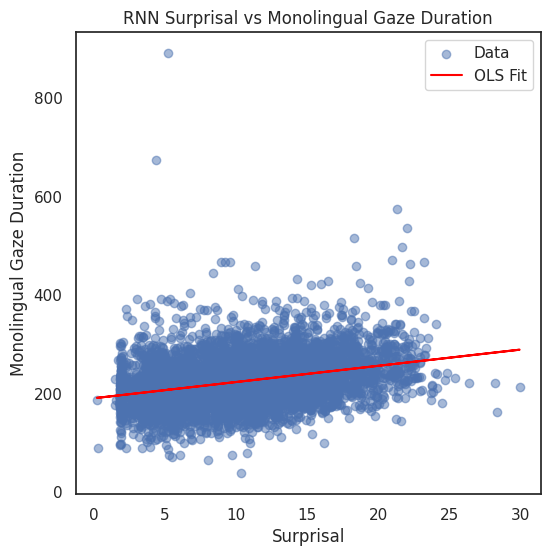

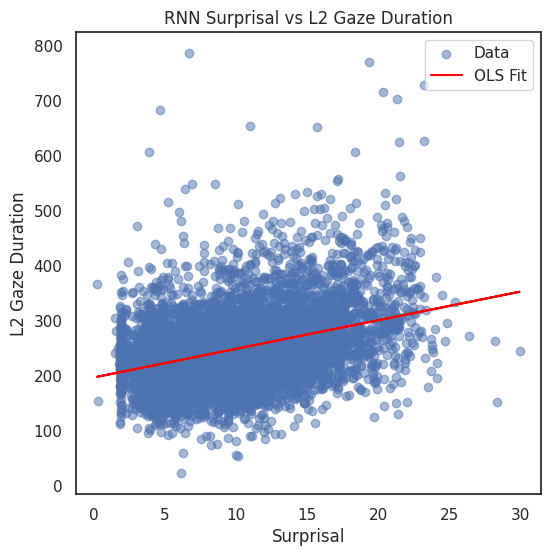

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit and summarize OLS model for RNN surprisal data
Y_rnn = english_harmonized['mono_gaze_dur']
X_rnn = english_harmonized['surp']
X_rnn = sm.add_constant(X_rnn)

lin_model_rnn = sm.OLS(Y_rnn, X_rnn).fit()

# Fit and summarize OLS model for 'l2_gaze_dur'
Y_l2 = english_harmonized['l2_gaze_dur']
X_l2 = english_harmonized['surp']
X_l2 = sm.add_constant(X_l2)

lin_model_l2 = sm.OLS(Y_l2, X_l2).fit()

# Print summaries
print(f"--------------------------RNN Surprisal Data Fit-----------------------")
print(lin_model_rnn.summary())
print(f"\n--------------------------L2 Gaze Duration Data Fit-----------------------")
print(lin_model_l2.summary())

# Plot for RNN Surprisal Data
plt.figure(figsize=(6, 6))
plt.scatter(X_rnn['surp'], Y_rnn, alpha=0.5, label='Data')
plt.plot(X_rnn['surp'], lin_model_rnn.fittedvalues, color='red', label='OLS Fit')
plt.title('RNN Surprisal vs Monolingual Gaze Duration')
plt.xlabel('Surprisal')
plt.ylabel('Monolingual Gaze Duration')
plt.legend()
plt.show()

# Plot for L2 Gaze Duration Data
plt.figure(figsize=(6, 6))
plt.scatter(X_l2['surp'], Y_l2, alpha=0.5, label='Data')
plt.plot(X_l2['surp'], lin_model_l2.fittedvalues, color='red', label='OLS Fit')
plt.title('RNN Surprisal vs L2 Gaze Duration')
plt.xlabel('Surprisal')
plt.ylabel('L2 Gaze Duration')
plt.legend()
plt.show()


Next Word

   Unnamed: 0      word  wlen       surp  mono_gaze_dur  mono_fix_pup_size  \
0           0       The     3   5.175300     226.692308        2684.346154   
1           1   intense     7  15.440462     276.769231        2666.653846   
2           2  interest     8  14.434409     293.384615        2601.705385   
3           3   aroused     7  20.291452     217.642857        2665.047857   
4           4        in     2   4.221605     171.428571        2883.357143   

   l2_gaze_dur  l2_fix_pup_size  log_frequency  mono_gaze_dur_next  \
0   232.625000      3344.875000      11.353698          276.769231   
1   367.555556      2985.463333       3.000000          293.384615   
2   399.750000      3126.453750       3.584963          217.642857   
3   327.444444      2974.528889       3.000000          171.428571   
4   143.500000      2924.000000       9.681238          215.750000   

   l2_gaze_dur_next  
0        367.555556  
1        399.750000  
2        327.444444  
3        143.500000  


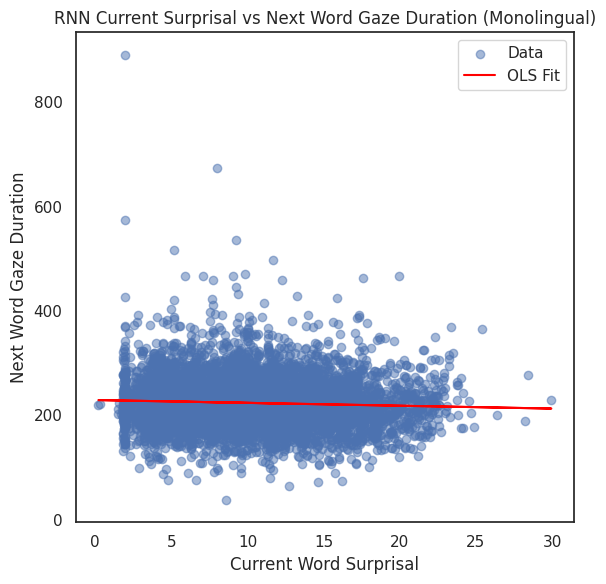

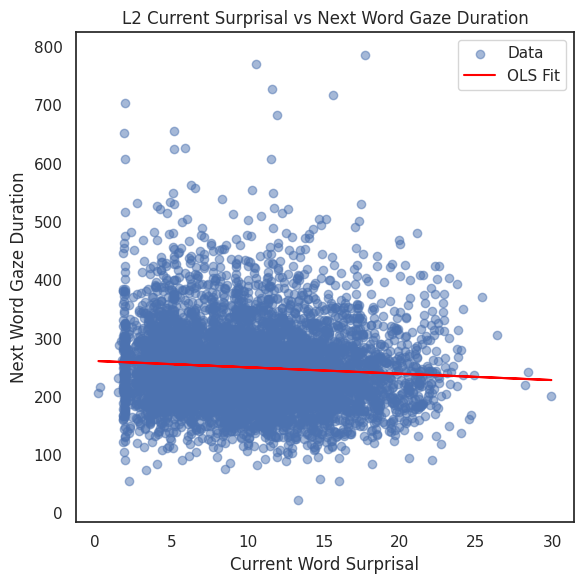

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Add new columns to the DataFrame for next word gaze durations
english_harmonized['mono_gaze_dur_next'] = english_harmonized['mono_gaze_dur'].shift(-1)
english_harmonized['l2_gaze_dur_next'] = english_harmonized['l2_gaze_dur'].shift(-1)

print(english_harmonized.head())


# Drop any rows with NaN values resulting from the shift
english_harmonized = english_harmonized.dropna(subset=['mono_gaze_dur_next', 'l2_gaze_dur_next'])

# Fit and summarize OLS model for RNN surprisal data with next word gaze duration
Y_rnn_next = english_harmonized['mono_gaze_dur_next']
X_rnn_next = english_harmonized['surp']
X_rnn_next = sm.add_constant(X_rnn_next)

lin_model_rnn_next = sm.OLS(Y_rnn_next, X_rnn_next).fit()

# Fit and summarize OLS model for 'l2_gaze_dur' with next word gaze duration
Y_l2_next = english_harmonized['l2_gaze_dur_next']
X_l2_next = english_harmonized['surp']
X_l2_next = sm.add_constant(X_l2_next)

lin_model_l2_next = sm.OLS(Y_l2_next, X_l2_next).fit()

# Print summaries
print(f"--------------------------RNN Current Surprisal vs Next Word Gaze Duration-----------------------")
print(lin_model_rnn_next.summary())
print(f"\n--------------------------L2 Current Surprisal vs Next Word Gaze Duration-----------------------")
print(lin_model_l2_next.summary())

# Plot for RNN Surprisal vs Next Word Gaze Duration
plt.figure(figsize=(6, 6))
plt.scatter(english_harmonized['surp'], english_harmonized['mono_gaze_dur_next'], alpha=0.5, label='Data')
plt.plot(english_harmonized['surp'], lin_model_rnn_next.fittedvalues, color='red', label='OLS Fit')
plt.title('RNN Current Surprisal vs Next Word Gaze Duration (Monolingual)')
plt.xlabel('Current Word Surprisal')
plt.ylabel('Next Word Gaze Duration')
plt.legend()
plt.tight_layout()  # Ensures uniform layout
plt.show()

# Plot for L2 Surprisal vs Next Word Gaze Duration
plt.figure(figsize=(6, 6))
plt.scatter(english_harmonized['surp'], english_harmonized['l2_gaze_dur_next'], alpha=0.5, label='Data')
plt.plot(english_harmonized['surp'], lin_model_l2_next.fittedvalues, color='red', label='OLS Fit')
plt.title('L2 - Current Surprisal vs Next Word Gaze Duration')
plt.xlabel('Current Word Surprisal')
plt.ylabel('Next Word Gaze Duration')
plt.legend()
plt.tight_layout()  # Ensures uniform layout
plt.show()


With binning

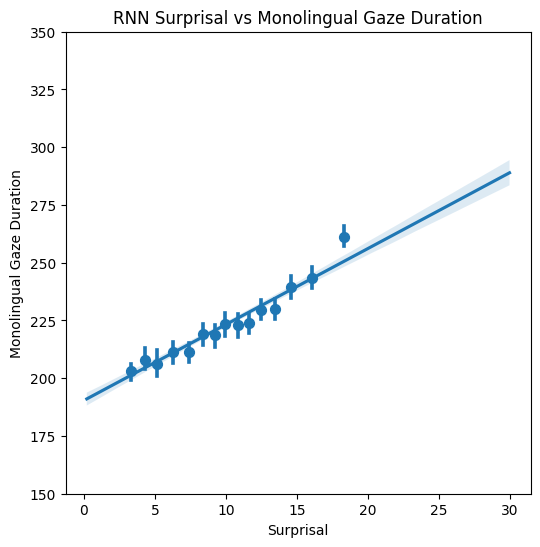

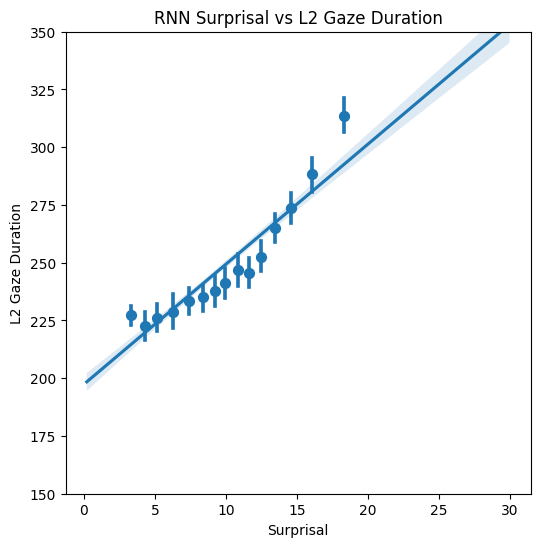

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# First plot for the RNN data with x_bins=15 and y-axis limit [250, 350]
plt.figure(figsize=(6, 6))
sns.regplot(x="surp", y="mono_gaze_dur", data=english_harmonized, x_bins=15)
plt.ylim([150, 350])
plt.title("RNN Surprisal vs Monolingual Gaze Duration")
plt.xlabel("Surprisal")
plt.ylabel("Monolingual Gaze Duration")

# Show the first plot
plt.show()

# Second plot for the L2 gaze duration data with x_bins=15 and y-axis limit [250, 350]
plt.figure(figsize=(6, 6))
sns.regplot(x="surp", y="l2_gaze_dur", data=english_harmonized, x_bins=15)
plt.ylim([150, 350])
plt.title("RNN Surprisal vs L2 Gaze Duration")
plt.xlabel("Surprisal")
plt.ylabel("L2 Gaze Duration")

# Show the second plot
plt.show()

##### Dutch

Current word

--------------------------RNN Surprisal Data Fit-----------------------
                            OLS Regression Results                            
Dep. Variable:            l1_gaze_dur   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     261.9
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           1.09e-57
Time:                        16:44:33   Log-Likelihood:                -32191.
No. Observations:                6039   AIC:                         6.439e+04
Df Residuals:                    6037   BIC:                         6.440e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

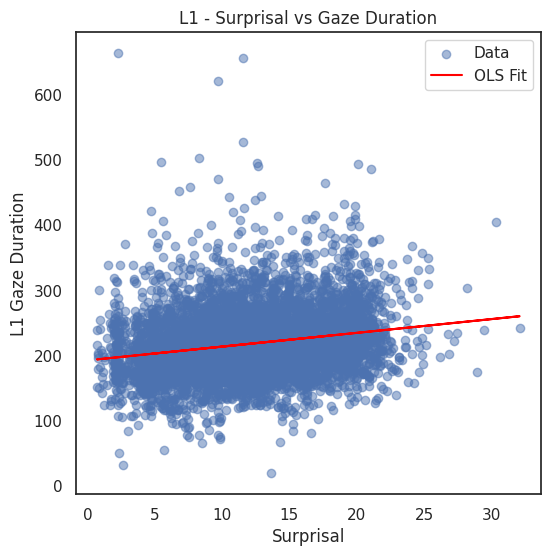

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit and summarize OLS model for RNN surprisal data
Y_rnn = dutch_harmonized['l1_gaze_dur']
X_rnn = dutch_harmonized['surp']
X_rnn = sm.add_constant(X_rnn)

lin_model_rnn = sm.OLS(Y_rnn, X_rnn).fit()

# Print summaries
print(f"--------------------------RNN Surprisal Data Fit-----------------------")
print(lin_model_rnn.summary())

# Plot for RNN Surprisal Data
plt.figure(figsize=(6, 6))
plt.scatter(X_rnn['surp'], Y_rnn, alpha=0.5, label='Data')
plt.plot(X_rnn['surp'], lin_model_rnn.fittedvalues, color='red', label='OLS Fit')
plt.title('L1 - Surprisal vs Gaze Duration')
plt.xlabel('Surprisal')
plt.ylabel('L1 Gaze Duration')
plt.legend()
plt.show()


Next word

--------------------------RNN Surprisal vs Next Word Gaze Duration (L1)-----------------------
                            OLS Regression Results                            
Dep. Variable:       l1_gaze_dur_next   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.672
Date:                Sun, 01 Sep 2024   Prob (F-statistic):            0.00324
Time:                        16:45:50   Log-Likelihood:                -32303.
No. Observations:                6037   AIC:                         6.461e+04
Df Residuals:                    6035   BIC:                         6.462e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

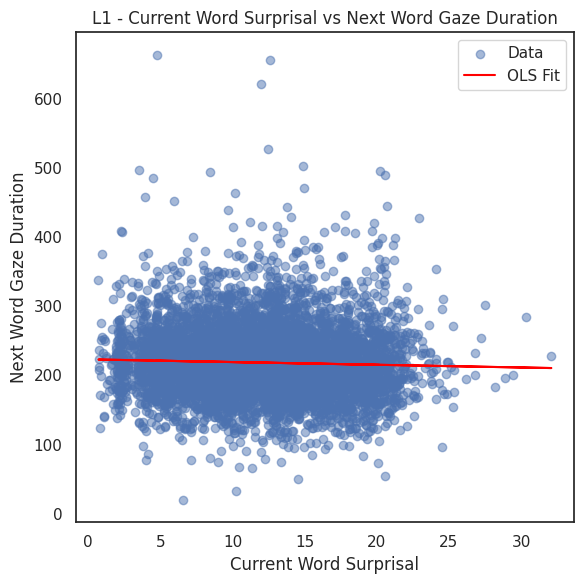

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Add new columns to the DataFrame for next word gaze duration
dutch_harmonized['l1_gaze_dur_next'] = dutch_harmonized['l1_gaze_dur'].shift(-1)

# Drop any rows with NaN values resulting from the shift
dutch_harmonized = dutch_harmonized.dropna(subset=['l1_gaze_dur_next'])

# Fit and summarize OLS model for RNN surprisal data with next word gaze duration
Y_rnn_next = dutch_harmonized['l1_gaze_dur_next']
X_rnn_next = dutch_harmonized['surp']
X_rnn_next = sm.add_constant(X_rnn_next)

lin_model_rnn_next = sm.OLS(Y_rnn_next, X_rnn_next).fit()

# Print summaries
print(f"--------------------------RNN Surprisal vs Next Word Gaze Duration (L1)-----------------------")
print(lin_model_rnn_next.summary())

# Plot for RNN Surprisal vs Next Word Gaze Duration
plt.figure(figsize=(6, 6))
plt.scatter(X_rnn_next['surp'], Y_rnn_next, alpha=0.5, label='Data')
plt.plot(X_rnn_next['surp'], lin_model_rnn_next.fittedvalues, color='red', label='OLS Fit')
plt.title('L1 - Current Word Surprisal vs Next Word Gaze Duration')
plt.xlabel('Current Word Surprisal')
plt.ylabel('Next Word Gaze Duration')
plt.legend()
plt.tight_layout()  # Ensures uniform layout
plt.show()


With binning

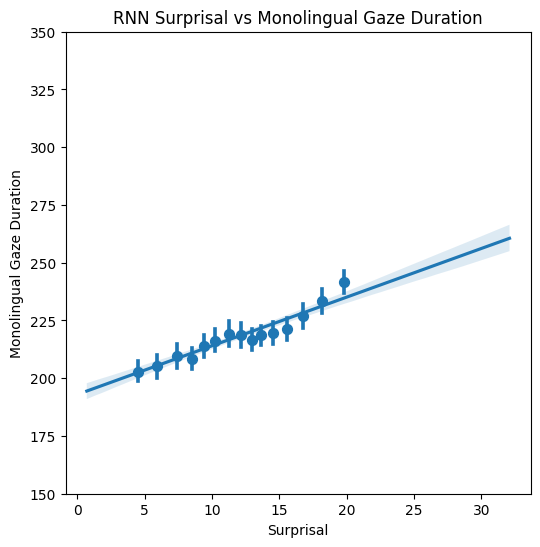

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
sns.regplot(x="surp", y="l1_gaze_dur", data=dutch_harmonized, x_bins=15)
plt.ylim([150, 350])
plt.title("RNN Surprisal vs Monolingual Gaze Duration")
plt.xlabel("Surprisal")
plt.ylabel("Monolingual Gaze Duration")

plt.show()

#### Pupil Size

Pupil Size vs Surprisal in every dataset

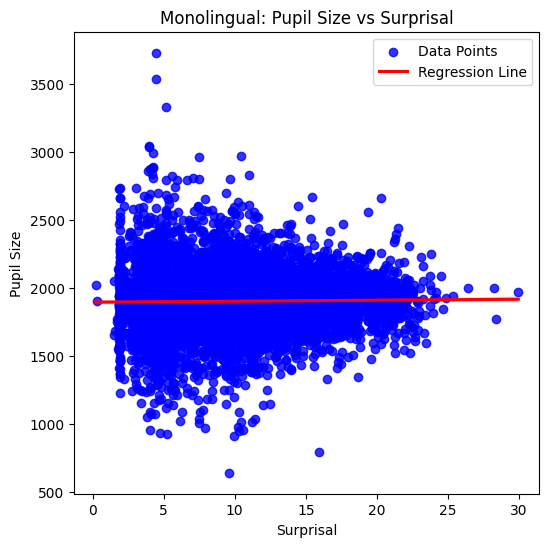

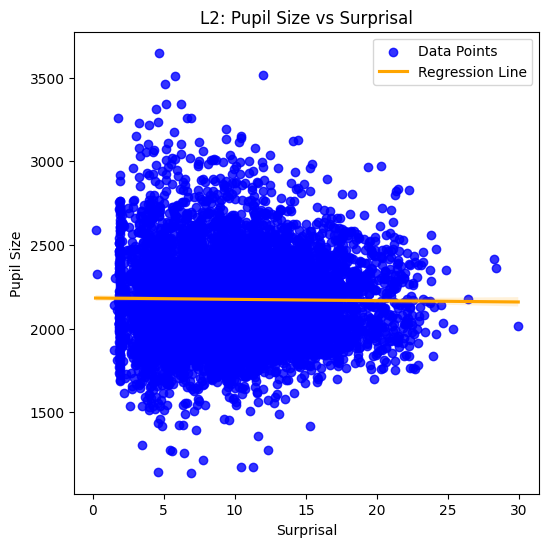

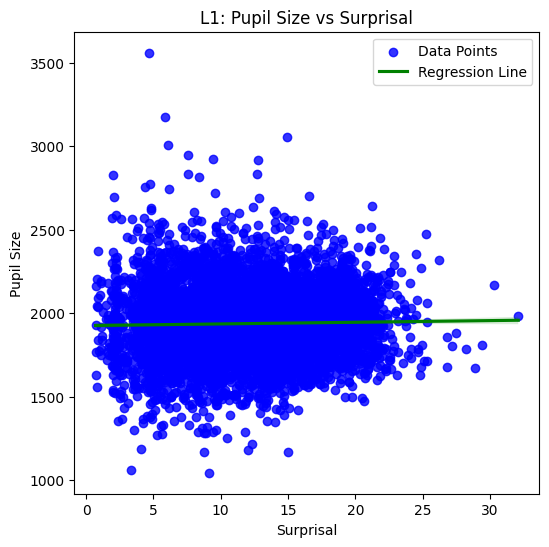

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot for Monolingual Pupil Size vs Surprisal
plt.figure(figsize=(6, 6))
sns.regplot(x="surp", y="mono_fix_pup_size", data=english_harmonized, color='blue', line_kws={"color": "red", "label": "Regression Line"})
plt.title('Monolingual: Pupil Size vs Surprisal')
plt.xlabel('Surprisal')
plt.ylabel('Pupil Size')
plt.legend(labels=['Data Points', 'Regression Line'])
plt.show()

# Plot for L2 Pupil Size vs Surprisal
plt.figure(figsize=(6, 6))
sns.regplot(x="surp", y="l2_fix_pup_size", data=english_harmonized, color='blue', line_kws={"color": "orange", "label": "Regression Line"})
plt.title('L2: Pupil Size vs Surprisal')
plt.xlabel('Surprisal')
plt.ylabel('Pupil Size')
plt.legend(labels=['Data Points', 'Regression Line'])
plt.show()

# Plot for L1 Pupil Size vs Surprisal
plt.figure(figsize=(6, 6))
sns.regplot(x="surp", y="l1_fix_pup_size", data=dutch_harmonized, color='blue', line_kws={"color": "green", "label": "Regression Line"})
plt.title('L1: Pupil Size vs Surprisal')
plt.xlabel('Surprisal')
plt.ylabel('Pupil Size')
plt.legend(labels=['Data Points', 'Regression Line'])
plt.show()

Summary vs Surprisal

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit and summarize OLS model for Monolingual Pupil Size vs Surprisal
Y_mono = english_harmonized['mono_fix_pup_size']
X_mono = english_harmonized[['surp']]
X_mono = sm.add_constant(X_mono)

lin_model_mono = sm.OLS(Y_mono, X_mono).fit()

# Fit and summarize OLS model for L2 Pupil Size vs Surprisal
Y_l2 = english_harmonized['l2_fix_pup_size']
X_l2 = english_harmonized[['surp']]
X_l2 = sm.add_constant(X_l2)

lin_model_l2 = sm.OLS(Y_l2, X_l2).fit()

# Fit and summarize OLS model for L1 Pupil Size vs Surprisal
Y_l1 = dutch_harmonized['l1_fix_pup_size']
X_l1 = dutch_harmonized[['surp']]
X_l1 = sm.add_constant(X_l1)

lin_model_l1 = sm.OLS(Y_l1, X_l1).fit()

# Print summaries
print(f"--------------------------Mono Surprisal Data Fit-----------------------")
print(lin_model_mono.summary())
print(f"\n--------------------------L2 Pupil Size Data Fit-----------------------")
print(lin_model_l2.summary())
print(f"\n--------------------------L1 Pupil Size Data Fit-----------------------")
print(lin_model_l1.summary())


--------------------------Mono Surprisal Data Fit-----------------------
                            OLS Regression Results                            
Dep. Variable:      mono_fix_pup_size   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.300
Date:                Sun, 01 Sep 2024   Prob (F-statistic):              0.254
Time:                        19:52:05   Log-Likelihood:                -41736.
No. Observations:                6041   AIC:                         8.348e+04
Df Residuals:                    6039   BIC:                         8.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit and summarize OLS model for RNN surprisal data
Y_mono = english_harmonized['mono_fix_pup_size']
X_mono = english_harmonized[['wlen', 'surp', 'log_frequency']]
X_mono = sm.add_constant(X_rnn)

lin_model_mono = sm.OLS(Y_mono, X_mono).fit()

# Fit and summarize OLS model for 'l2_fix_pupil_size'
Y_l2 = english_harmonized['l2_fix_pup_size']
X_l2 = english_harmonized[['wlen', 'surp', 'log_frequency']]
X_l2 = sm.add_constant(X_l2)

lin_model_l2 = sm.OLS(Y_l2, X_l2).fit()

Y_l1 = dutch_harmonized['l1_fix_pup_size']
X_l1 = dutch_harmonized[['wlen', 'surp', 'log_frequency']]
X_l1 = sm.add_constant(X_l1)

lin_model_l1 = sm.OLS(Y_l1, X_l1).fit()

# Print summaries
print(f"--------------------------Mono Surprisal Data Fit-----------------------")
print(lin_model_mono.summary())
print(f"\n--------------------------L2 Pupil Size Data Fit-----------------------")
print(lin_model_l2.summary())
print(f"\n--------------------------L1 Pupil Size Data Fit-----------------------")
print(lin_model_l1.summary())

--------------------------Mono Surprisal Data Fit-----------------------
                            OLS Regression Results                            
Dep. Variable:      mono_fix_pup_size   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.297
Date:                Sun, 01 Sep 2024   Prob (F-statistic):            0.00491
Time:                        19:16:22   Log-Likelihood:                -41730.
No. Observations:                6041   AIC:                         8.347e+04
Df Residuals:                    6037   BIC:                         8.350e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

Progression of the Pupil Size

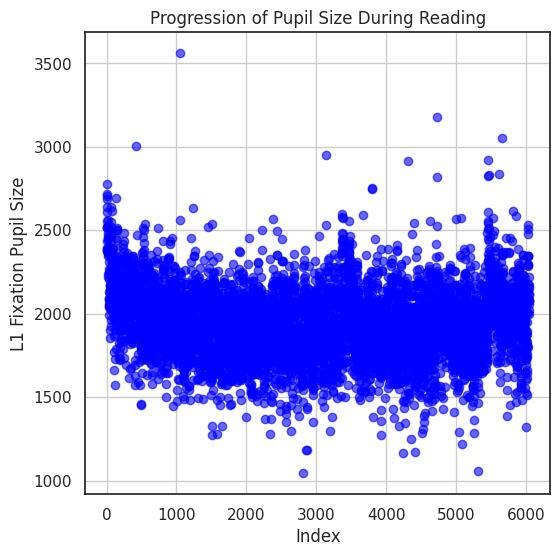

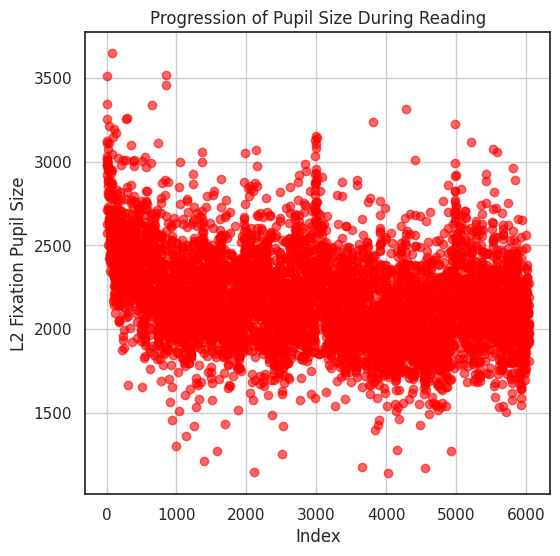

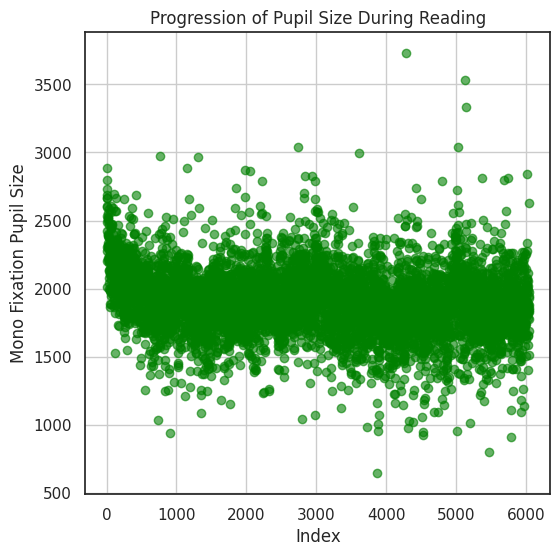

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(dutch_harmonized.index, dutch_harmonized['l1_fix_pup_size'], color='blue', marker='o', linestyle='-', alpha=0.6)
plt.title('Progression of Pupil Size During Reading')
plt.xlabel('Index')
plt.ylabel('L1 Fixation Pupil Size')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(english_harmonized.index, english_harmonized['l2_fix_pup_size'], color='red', marker='o', linestyle='-', alpha=0.6)
plt.title('Progression of Pupil Size During Reading')
plt.xlabel('Index')
plt.ylabel('L2 Fixation Pupil Size')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(english_harmonized.index, english_harmonized['mono_fix_pup_size'], color='green', marker='o', linestyle='-', alpha=0.6)
plt.title('Progression of Pupil Size During Reading')
plt.xlabel('Index')
plt.ylabel('Mono Fixation Pupil Size')
plt.grid(True)
plt.show()

Adding pixel info

In [ ]:
additional_info_english = pd.read_excel('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/RT_INFO/EnglishMaterial.xlsx')
additional_info_dutch = pd.read_excel('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/open_ended_task/RT_INFO/DutchMaterials.xlsx')
print(additional_info_english.head())
print(additional_info_dutch.head())

  WORD_ID SENTENCE_ID  CHRON_ID      WORD PART_OF_SPEECH  CONTENT_WORD  \
0   1-5-1         1-1         1       The        Article             0   
1   1-5-2         1-1         2   intense      Adjective             1   
2   1-5-3         1-1         3  interest           Noun             1   
3   1-5-4         1-1         4   aroused           Verb             1   
4   1-5-5         1-1         5        in    Preposition             0   

   WORD_LENGTH  IA_AREA  IA_TOP  IA_BOTTOM  IA_LEFT  IA_RIGHT  
0            3     3087      93        142       66       129  
1            7     3920      93        142      129       209  
2            8     4410      93        142      209       299  
3            7     3969      93        142      299       380  
4            2     1421      93        142      380       409  
   IA_ID SENTENCE_ID  CHRON_ID            WORD PART_OF_SPEECH  CONTENT_WORD  \
0  1-5-1         1-1         1              De        Article             0   
1  1-5-2     

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
pixel_area_english = additional_info_english[['WORD_ID', 'IA_AREA']].copy()
pixel_area_dutch = additional_info_dutch[['IA_ID', 'IA_AREA']].copy().rename(columns={'IA_ID': 'WORD_ID'})
print(pixel_area_english.head())
print(pixel_area_dutch.head())

  WORD_ID  IA_AREA
0   1-5-1     3087
1   1-5-2     3920
2   1-5-3     4410
3   1-5-4     3969
4   1-5-5     1421
  WORD_ID  IA_AREA
0   1-5-1     2597
1   1-5-2     3430
2   1-5-3     7399
3   1-5-4     1911
4   1-5-5     1960


In [ ]:
dutch_with_pixel_info = pd.merge(dutch_harmonized, pixel_area_dutch, right_on='WORD_ID', left_on='code')
english_with_pixel_info = pd.merge(english_harmonized, pixel_area_english, right_on='WORD_ID', left_on='code')
print(dutch_with_pixel_info.head())
print(english_with_pixel_info.head())

   Unnamed: 0.1  Unnamed: 0            word  wlen       surp  l1_gaze_dur  \
0             0           0              De   2.0   4.718139   191.222222   
1             1           1          enorme   6.0  16.552916   198.666667   
2             2           2  belangstelling  14.0  12.872829   312.222222   
3             3           3             die   3.0   8.031992   156.000000   
4             4           4             het   3.0   9.582423   197.250000   

   l1_fix_pup_size   code  log_frequency WORD_ID  IA_AREA  
0      2774.944444  1-5-1      10.941781   1-5-1     2597  
1      2702.777778  1-5-2       3.459432   1-5-2     3430  
2      2688.511111  1-5-3       2.321928   1-5-3     7399  
3      2607.333333  1-5-4       9.116344   1-5-4     1911  
4      2719.062500  1-5-5      10.796040   1-5-5     1960  
   Unnamed: 0.1  Unnamed: 0      word  wlen       surp  mono_gaze_dur  \
0             0           0       The     3   5.175300     226.692308   
1             1           1   i

In [ ]:
print(len(english_with_pixel_info[['wlen', 'surp', 'log_frequency', 'IA_AREA']]))
print(len(english_with_pixel_info[['mono_fix_pup_size']]))

6014
6014


In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit and summarize OLS model for RNN surprisal data
Y_mono = english_with_pixel_info['mono_fix_pup_size']
X_mono = english_with_pixel_info[['IA_AREA', 'surp', 'wlen']]
X_mono = sm.add_constant(X_mono)

lin_model_mono = sm.OLS(Y_mono, X_mono).fit()

# Fit and summarize OLS model for 'l2_fix_pupil_size'
Y_l2 = english_with_pixel_info['l2_fix_pup_size']
X_l2 = english_with_pixel_info[['IA_AREA', 'surp', 'wlen']]
X_l2 = sm.add_constant(X_l2)

lin_model_l2 = sm.OLS(Y_l2, X_l2).fit()

Y_l1 = dutch_with_pixel_info['l1_fix_pup_size']
X_l1 = dutch_with_pixel_info[['IA_AREA', 'surp', 'wlen']]
X_l1 = sm.add_constant(X_l1)

lin_model_l1 = sm.OLS(Y_l1, X_l1).fit()

# Print summaries
print(f"--------------------------Mono Surprisal Data Fit-----------------------")
print(lin_model_mono.summary())
print(f"\n--------------------------L2 Pupil Size Data Fit-----------------------")
print(lin_model_l2.summary())
print(f"\n--------------------------L1 Pupil Size Data Fit-----------------------")
print(lin_model_l1.summary())

--------------------------Mono Surprisal Data Fit-----------------------
                            OLS Regression Results                            
Dep. Variable:      mono_fix_pup_size   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     17.45
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           2.80e-11
Time:                        20:00:02   Log-Likelihood:                -41530.
No. Observations:                6014   AIC:                         8.307e+04
Df Residuals:                    6010   BIC:                         8.309e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit and summarize OLS model for RNN surprisal data
Y_mono = english_with_pixel_info['mono_fix_pup_size']
X_mono = english_with_pixel_info[['IA_AREA', 'surp', 'wlen']]
X_mono = sm.add_constant(X_mono)

lin_model_mono = sm.OLS(Y_mono, X_mono).fit()

# Fit and summarize OLS model for 'l2_fix_pupil_size'
Y_l2 = english_with_pixel_info['l2_fix_pup_size']
X_l2 = english_with_pixel_info[['IA_AREA', 'surp', 'wlen']]
X_l2 = sm.add_constant(X_l2)

lin_model_l2 = sm.OLS(Y_l2, X_l2).fit()

Y_l1 = dutch_with_pixel_info['l1_fix_pup_size']
X_l1 = dutch_with_pixel_info[['IA_AREA', 'surp', 'wlen']]
X_l1 = sm.add_constant(X_l1)

lin_model_l1 = sm.OLS(Y_l1, X_l1).fit()

# Print summaries
print(f"--------------------------Mono Surprisal Data Fit-----------------------")
print(lin_model_mono.summary())
print(f"\n--------------------------L2 Pupil Size Data Fit-----------------------")
print(lin_model_l2.summary())
print(f"\n--------------------------L1 Pupil Size Data Fit-----------------------")
print(lin_model_l1.summary())

--------------------------Mono Surprisal Data Fit-----------------------
                            OLS Regression Results                            
Dep. Variable:      mono_fix_pup_size   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     17.45
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           2.80e-11
Time:                        20:00:54   Log-Likelihood:                -41530.
No. Observations:                6014   AIC:                         8.307e+04
Df Residuals:                    6010   BIC:                         8.309e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------